In [1]:
# Setup: imports and paths (DoS-focused version)
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

pd.set_option('display.max_columns', 120)
sns.set_theme(style='whitegrid')

DATA_DIR = os.path.join(os.getcwd(), 'datasets')
assert os.path.isdir(DATA_DIR), f"Missing datasets dir: {DATA_DIR}"
print('PyTorch:', torch.__version__)
print('Data dir:', DATA_DIR)


PyTorch: 2.8.0+cpu
Data dir: /app/datasets


In [2]:
# Config
LABEL_COL = 'Label'
NROWS_PER_CSV = 200_000   # sample more for V2; adjust as needed
BATCH_SIZE = 512
EPOCHS = 20
LOG_INTERVAL = 50
MAX_BATCHES = None
SEED = 42

import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


In [3]:
# Load CSVs and combine
csv_paths = sorted(glob.glob(os.path.join(DATA_DIR, '*.csv')))
assert csv_paths, 'No CSVs found in datasets/'
print('Found CSVs:', len(csv_paths))

frames = []
for p in csv_paths:
    try:
        df = pd.read_csv(p, nrows=NROWS_PER_CSV)
        df['__source__'] = os.path.basename(p)
        frames.append(df)
        print('Loaded', os.path.basename(p), df.shape)
    except Exception as e:
        print('Skip', os.path.basename(p), e)

data = pd.concat(frames, ignore_index=True)
print('Combined shape:', data.shape)

data.head()


Found CSVs: 8
Loaded Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv (200000, 80)
Loaded Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv (200000, 80)
Loaded Friday-WorkingHours-Morning.pcap_ISCX.csv (191033, 80)
Loaded Monday-WorkingHours.pcap_ISCX.csv (200000, 80)
Loaded Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv (200000, 80)
Loaded Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv (170366, 80)
Loaded Tuesday-WorkingHours.pcap_ISCX.csv (200000, 80)
Loaded Wednesday-workingHours.pcap_ISCX.csv (200000, 80)
Combined shape: (1561399, 80)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,__source__
0,54865,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
1,55054,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,9174.311927,9174.311927,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
2,55055,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,19230.769230,19230.769230,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
3,46236,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34,34,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,29411.764710,29411.764710,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
4,54863,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv


In [4]:
# Normalize columns and preview labels
orig_cols = list(data.columns)
data.columns = [str(c).strip() for c in data.columns]
if orig_cols != list(data.columns):
    print('Normalized column names (stripped whitespace).')

assert LABEL_COL in data.columns, f"Label column '{LABEL_COL}' missing in data."
print('Label unique values (sample):', data[LABEL_COL].astype(str).unique()[:20])


Normalized column names (stripped whitespace).
Label unique values (sample): ['BENIGN' 'DDoS' 'PortScan' 'Bot' 'Infiltration'
 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection' 'FTP-Patator' 'SSH-Patator' 'DoS slowloris'
 'DoS Slowhttptest' 'DoS Hulk']


In [5]:
# Feature selection: use all numeric columns except the label/meta columns
EXCLUDE_COLUMNS = {LABEL_COL, '__source__'}
numeric_cols = [
    col for col in data.columns
    if col not in EXCLUDE_COLUMNS and pd.api.types.is_numeric_dtype(data[col])
]

if not numeric_cols:
    raise ValueError('No numeric features found after excluding labels/meta columns.')

FEATURES = sorted(numeric_cols)
print(f'Using {len(FEATURES)} numeric features.')
X_df = data[FEATURES].copy()


Using 78 numeric features.


In [6]:
# Clean NaNs/Infs and scale
X_df = X_df.replace([np.inf, -np.inf], np.nan)
na_ratio = X_df.isna().mean().sort_values(ascending=False)
print('NaN ratio (top):')
print(na_ratio.head(10))

X_df = X_df.fillna(0.0).astype(np.float32)

# Standard scaling (z-score)
X_mean = X_df.mean()
X_std = X_df.std().replace(0, 1)
X = ((X_df - X_mean) / X_std).astype(np.float32)

# Labels
y_cat = data[LABEL_COL].astype('category')
class_names = list(y_cat.cat.categories)
y = y_cat.cat.codes.values.astype(np.int64)
num_classes = len(class_names)
print('X shape:', X.shape, '| classes:', num_classes)
print('Classes:', class_names[:20])


NaN ratio (top):
Flow Bytes/s             0.000956
Flow Packets/s           0.000956
ACK Flag Count           0.000000
Idle Std                 0.000000
Idle Min                 0.000000
Idle Mean                0.000000
Idle Max                 0.000000
Fwd URG Flags            0.000000
Fwd Packets/s            0.000000
Fwd Packet Length Std    0.000000
dtype: float64
X shape: (1561399, 78) | classes: 13
Classes: ['BENIGN', 'Bot', 'DDoS', 'DoS Hulk', 'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 'Infiltration', 'PortScan', 'SSH-Patator', 'Web Attack � Brute Force', 'Web Attack � Sql Injection', 'Web Attack � XSS']


In [7]:
# Stratified 60/20/20 split using sklearn
from sklearn.model_selection import train_test_split

# First split: Train vs temp (train=60%, temp=40%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X.values, y, test_size=0.20, random_state=SEED, stratify=y
)
# Now split remaining into train and val (train: 60% of total, val: 20% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=SEED, stratify=y_temp
)

print('Shapes:', X_train.shape, X_val.shape, X_test.shape)


Shapes: (936839, 78) (312280, 78) (312280, 78)


In [8]:
# Torch datasets and loaders
import torch
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight

X_train_t = torch.from_numpy(X_train).float()
X_val_t = torch.from_numpy(X_val).float()
X_test_t = torch.from_numpy(X_test).float()
y_train_t = torch.from_numpy(y_train)
y_val_t = torch.from_numpy(y_val)
y_test_t = torch.from_numpy(y_test)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_class_counts = np.bincount(y_train, minlength=num_classes)
print('Train class counts (pre-balance):')
for name, count in zip(class_names, train_class_counts):
    print(f'  {name}: {int(count)}')

class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(num_classes), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32)
print('Applied class weights:')
for name, weight in zip(class_names, class_weights.tolist()):
    print(f'  {name}: {weight:.4f}')
sample_weights = class_weights[y_train_t].double()
train_sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=train_sampler)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

class MLP(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        hidden = max(32, min(512, in_dim * 2))
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.BatchNorm1d(hidden),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.BatchNorm1d(hidden),
            nn.Linear(hidden, out_dim),
        )
    def forward(self, x):
        return self.net(x)

in_dim = X_train.shape[1]
model = MLP(in_dim, num_classes)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print('Using device:', device)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)


Train class counts (pre-balance):
  BENIGN: 707860
  Bot: 1180
  DDoS: 76816
  DoS Hulk: 71206
  DoS Slowhttptest: 3299
  DoS slowloris: 3478
  FTP-Patator: 4762
  Infiltration: 19
  PortScan: 65608
  SSH-Patator: 1303
  Web Attack � Brute Force: 904
  Web Attack � Sql Injection: 13
  Web Attack � XSS: 391
Applied class weights:
  BENIGN: 0.1018
  Bot: 61.0716
  DDoS: 0.9381
  DoS Hulk: 1.0121
  DoS Slowhttptest: 21.8444
  DoS slowloris: 20.7201
  FTP-Patator: 15.1333
  Infiltration: 3792.8704
  PortScan: 1.0984
  SSH-Patator: 55.3066
  Web Attack � Brute Force: 79.7174
  Web Attack � Sql Injection: 5543.4263
  Web Attack � XSS: 184.3083
Using device: cpu


In [9]:
# Training
try:
    from tqdm import tqdm
except Exception:
    def tqdm(x, **kwargs):
        return x


def accuracy(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    num_train = 0
    for b_idx, (xb, yb) in enumerate(tqdm(train_dl, leave=False)):
        if MAX_BATCHES and b_idx >= MAX_BATCHES:
            break
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
        train_acc += accuracy(out, yb) * xb.size(0)
        num_train += xb.size(0)
        if (b_idx + 1) % LOG_INTERVAL == 0:
            print(f'Epoch {epoch} | Batch {b_idx+1} | loss={loss.item():.4f}')

    train_loss /= max(1, num_train)
    train_acc /= max(1, num_train)

    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    num_val = 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            out = model(xb)
            loss = criterion(out, yb.long())
            val_loss += loss.item() * xb.size(0)
            val_acc += accuracy(out, yb) * xb.size(0)
            num_val += xb.size(0)
    val_loss /= max(1, num_val)
    val_acc /= max(1, num_val)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f'Epoch {epoch}: train_loss={train_loss:.4f} val_loss={val_loss:.4f} train_acc={train_acc:.4f} val_acc={val_acc:.4f}')


  5%|▍         | 85/1830 [00:00<00:11, 156.50it/s]

Epoch 1 | Batch 50 | loss=0.1357


  6%|▌         | 102/1830 [00:00<00:10, 158.61it/s]

Epoch 1 | Batch 100 | loss=0.0654


  8%|▊         | 152/1830 [00:01<00:15, 107.38it/s]

Epoch 1 | Batch 150 | loss=0.0491


 13%|█▎        | 233/1830 [00:01<00:10, 147.30it/s]

Epoch 1 | Batch 200 | loss=0.0475


 14%|█▍        | 264/1830 [00:02<00:11, 136.78it/s]

Epoch 1 | Batch 250 | loss=0.0384


 18%|█▊        | 328/1830 [00:02<00:08, 178.45it/s]

Epoch 1 | Batch 300 | loss=0.0436


 20%|██        | 369/1830 [00:02<00:09, 149.94it/s]

Epoch 1 | Batch 350 | loss=0.0498


 23%|██▎       | 421/1830 [00:03<00:10, 140.68it/s]

Epoch 1 | Batch 400 | loss=0.0323


 26%|██▌       | 479/1830 [00:03<00:08, 163.56it/s]

Epoch 1 | Batch 450 | loss=0.0386


 28%|██▊       | 521/1830 [00:03<00:07, 178.63it/s]

Epoch 1 | Batch 500 | loss=0.0515


 32%|███▏      | 582/1830 [00:04<00:06, 191.38it/s]

Epoch 1 | Batch 550 | loss=0.0383


 33%|███▎      | 602/1830 [00:04<00:06, 184.13it/s]

Epoch 1 | Batch 600 | loss=0.0361


 38%|███▊      | 689/1830 [00:04<00:06, 180.96it/s]

Epoch 1 | Batch 650 | loss=0.0344


 40%|███▉      | 729/1830 [00:04<00:05, 187.17it/s]

Epoch 1 | Batch 700 | loss=0.0332


 43%|████▎     | 790/1830 [00:05<00:05, 192.58it/s]

Epoch 1 | Batch 750 | loss=0.0330


 44%|████▍     | 810/1830 [00:05<00:05, 186.64it/s]

Epoch 1 | Batch 800 | loss=0.0293


 49%|████▊     | 891/1830 [00:05<00:05, 178.53it/s]

Epoch 1 | Batch 850 | loss=0.0361


 51%|█████     | 930/1830 [00:06<00:04, 182.49it/s]

Epoch 1 | Batch 900 | loss=0.0353


 53%|█████▎    | 969/1830 [00:06<00:04, 182.21it/s]

Epoch 1 | Batch 950 | loss=0.0351


 55%|█████▌    | 1011/1830 [00:06<00:04, 187.32it/s]

Epoch 1 | Batch 1000 | loss=0.0276


 60%|█████▉    | 1093/1830 [00:06<00:03, 188.87it/s]

Epoch 1 | Batch 1050 | loss=0.0302


 62%|██████▏   | 1133/1830 [00:07<00:03, 189.19it/s]

Epoch 1 | Batch 1100 | loss=0.0373


 64%|██████▍   | 1174/1830 [00:07<00:03, 192.49it/s]

Epoch 1 | Batch 1150 | loss=0.0327


 67%|██████▋   | 1217/1830 [00:07<00:03, 154.63it/s]

Epoch 1 | Batch 1200 | loss=0.0336


 70%|██████▉   | 1274/1830 [00:08<00:03, 161.84it/s]

Epoch 1 | Batch 1250 | loss=0.0379


 73%|███████▎  | 1338/1830 [00:08<00:02, 185.11it/s]

Epoch 1 | Batch 1300 | loss=0.0346


 76%|███████▌  | 1383/1830 [00:08<00:02, 204.79it/s]

Epoch 1 | Batch 1350 | loss=0.0366


 78%|███████▊  | 1429/1830 [00:08<00:02, 190.29it/s]

Epoch 1 | Batch 1400 | loss=0.0370


 82%|████████▏ | 1494/1830 [00:09<00:01, 189.71it/s]

Epoch 1 | Batch 1450 | loss=0.0278


 84%|████████▍ | 1539/1830 [00:09<00:01, 206.18it/s]

Epoch 1 | Batch 1500 | loss=0.0287


 87%|████████▋ | 1584/1830 [00:09<00:01, 210.00it/s]

Epoch 1 | Batch 1550 | loss=0.0249


 89%|████████▉ | 1631/1830 [00:09<00:00, 210.12it/s]

Epoch 1 | Batch 1600 | loss=0.0283


 90%|█████████ | 1653/1830 [00:09<00:00, 207.03it/s]

Epoch 1 | Batch 1650 | loss=0.0279


 95%|█████████▌| 1745/1830 [00:10<00:00, 195.94it/s]

Epoch 1 | Batch 1700 | loss=0.0232


 98%|█████████▊| 1794/1830 [00:10<00:00, 216.07it/s]

Epoch 1 | Batch 1750 | loss=0.0419


Epoch 1 | Batch 1800 | loss=0.0286
Epoch 1: train_loss=0.0472 val_loss=0.8802 train_acc=0.6874 val_acc=0.2168


  5%|▍         | 85/1830 [00:00<00:11, 150.12it/s]

Epoch 2 | Batch 50 | loss=0.0268


  6%|▌         | 108/1830 [00:00<00:10, 171.21it/s]

Epoch 2 | Batch 100 | loss=0.0327


 10%|▉         | 174/1830 [00:01<00:08, 185.46it/s]

Epoch 2 | Batch 150 | loss=0.0281


 12%|█▏        | 221/1830 [00:01<00:09, 169.80it/s]

Epoch 2 | Batch 200 | loss=0.0351


 16%|█▌        | 292/1830 [00:01<00:07, 206.71it/s]

Epoch 2 | Batch 250 | loss=0.0372


 18%|█▊        | 338/1830 [00:01<00:07, 211.41it/s]

Epoch 2 | Batch 300 | loss=0.0307


 21%|██        | 384/1830 [00:02<00:07, 187.12it/s]

Epoch 2 | Batch 350 | loss=0.0342


 23%|██▎       | 429/1830 [00:02<00:06, 203.25it/s]

Epoch 2 | Batch 400 | loss=0.0402


 26%|██▌       | 475/1830 [00:02<00:06, 213.29it/s]

Epoch 2 | Batch 450 | loss=0.0299


 30%|██▉       | 545/1830 [00:03<00:06, 204.34it/s]

Epoch 2 | Batch 500 | loss=0.0434


 31%|███       | 567/1830 [00:03<00:07, 173.15it/s]

Epoch 2 | Batch 550 | loss=0.0430


 35%|███▍      | 633/1830 [00:03<00:06, 199.33it/s]

Epoch 2 | Batch 600 | loss=0.0318


 37%|███▋      | 681/1830 [00:03<00:05, 216.37it/s]

Epoch 2 | Batch 650 | loss=0.0253


 40%|███▉      | 729/1830 [00:03<00:04, 226.45it/s]

Epoch 2 | Batch 700 | loss=0.0403


 42%|████▏     | 774/1830 [00:04<00:04, 213.97it/s]

Epoch 2 | Batch 750 | loss=0.0327


 45%|████▍     | 818/1830 [00:04<00:05, 173.80it/s]

Epoch 2 | Batch 800 | loss=0.0338


 48%|████▊     | 882/1830 [00:04<00:04, 194.31it/s]

Epoch 2 | Batch 850 | loss=0.0288


 51%|█████     | 929/1830 [00:04<00:04, 211.38it/s]

Epoch 2 | Batch 900 | loss=0.0283


 53%|█████▎    | 977/1830 [00:05<00:03, 223.30it/s]

Epoch 2 | Batch 950 | loss=0.0229


 56%|█████▌    | 1023/1830 [00:05<00:03, 219.39it/s]

Epoch 2 | Batch 1000 | loss=0.0281


 60%|█████▉    | 1094/1830 [00:05<00:03, 200.96it/s]

Epoch 2 | Batch 1050 | loss=0.0411


 62%|██████▏   | 1140/1830 [00:05<00:03, 213.02it/s]

Epoch 2 | Batch 1100 | loss=0.0295


 65%|██████▍   | 1186/1830 [00:06<00:03, 203.83it/s]

Epoch 2 | Batch 1150 | loss=0.0271


 67%|██████▋   | 1234/1830 [00:06<00:02, 217.55it/s]

Epoch 2 | Batch 1200 | loss=0.0362


 69%|██████▊   | 1257/1830 [00:06<00:03, 190.52it/s]

Epoch 2 | Batch 1250 | loss=0.0368


 72%|███████▏  | 1319/1830 [00:06<00:03, 163.01it/s]

Epoch 2 | Batch 1300 | loss=0.0324


 76%|███████▌  | 1387/1830 [00:07<00:02, 199.24it/s]

Epoch 2 | Batch 1350 | loss=0.0382


 78%|███████▊  | 1432/1830 [00:07<00:01, 199.98it/s]

Epoch 2 | Batch 1400 | loss=0.0332


 80%|███████▉  | 1455/1830 [00:07<00:01, 207.56it/s]

Epoch 2 | Batch 1450 | loss=0.0307


 83%|████████▎ | 1526/1830 [00:08<00:01, 197.82it/s]

Epoch 2 | Batch 1500 | loss=0.0345


 85%|████████▍ | 1550/1830 [00:08<00:01, 208.66it/s]

Epoch 2 | Batch 1550 | loss=0.0265


 88%|████████▊ | 1606/1830 [00:08<00:02, 100.66it/s]

Epoch 2 | Batch 1600 | loss=0.0442


 92%|█████████▏| 1682/1830 [00:09<00:00, 155.01it/s]

Epoch 2 | Batch 1650 | loss=0.0299


 94%|█████████▍| 1728/1830 [00:09<00:00, 187.66it/s]

Epoch 2 | Batch 1700 | loss=0.0397


 98%|█████████▊| 1796/1830 [00:09<00:00, 188.52it/s]

Epoch 2 | Batch 1750 | loss=0.0284


 99%|█████████▉| 1817/1830 [00:09<00:00, 176.53it/s]

Epoch 2 | Batch 1800 | loss=0.0267


Epoch 2: train_loss=0.0317 val_loss=0.8030 train_acc=0.7978 val_acc=0.3022


  4%|▍         | 71/1830 [00:00<00:11, 149.60it/s]

Epoch 3 | Batch 50 | loss=0.0278


  7%|▋         | 131/1830 [00:00<00:10, 161.74it/s]

Epoch 3 | Batch 100 | loss=0.0279


  9%|▉         | 172/1830 [00:01<00:09, 179.74it/s]

Epoch 3 | Batch 150 | loss=0.0277


 13%|█▎        | 239/1830 [00:01<00:07, 203.07it/s]

Epoch 3 | Batch 200 | loss=0.0297


 16%|█▌        | 288/1830 [00:01<00:07, 219.79it/s]

Epoch 3 | Batch 250 | loss=0.0376


 17%|█▋        | 311/1830 [00:01<00:06, 221.91it/s]

Epoch 3 | Batch 300 | loss=0.0337


 21%|██        | 380/1830 [00:02<00:07, 198.45it/s]

Epoch 3 | Batch 350 | loss=0.0317


 23%|██▎       | 428/1830 [00:02<00:06, 215.33it/s]

Epoch 3 | Batch 400 | loss=0.0270


 26%|██▌       | 476/1830 [00:02<00:06, 224.66it/s]

Epoch 3 | Batch 450 | loss=0.0284


 29%|██▊       | 523/1830 [00:02<00:06, 197.57it/s]

Epoch 3 | Batch 500 | loss=0.0268


 31%|███       | 565/1830 [00:03<00:07, 162.71it/s]

Epoch 3 | Batch 550 | loss=0.0263


 35%|███▍      | 637/1830 [00:03<00:05, 206.59it/s]

Epoch 3 | Batch 600 | loss=0.0385


 37%|███▋      | 684/1830 [00:03<00:05, 200.06it/s]

Epoch 3 | Batch 650 | loss=0.0301


 40%|███▉      | 731/1830 [00:03<00:05, 215.00it/s]

Epoch 3 | Batch 700 | loss=0.0276


 43%|████▎     | 778/1830 [00:04<00:05, 196.69it/s]

Epoch 3 | Batch 750 | loss=0.0264


 46%|████▌     | 845/1830 [00:04<00:04, 202.98it/s]

Epoch 3 | Batch 800 | loss=0.0313


 49%|████▊     | 892/1830 [00:04<00:04, 215.83it/s]

Epoch 3 | Batch 850 | loss=0.0243


 51%|█████▏    | 938/1830 [00:04<00:04, 219.72it/s]

Epoch 3 | Batch 900 | loss=0.0310


 54%|█████▍    | 984/1830 [00:05<00:03, 220.08it/s]

Epoch 3 | Batch 950 | loss=0.0239


 55%|█████▌    | 1008/1830 [00:05<00:03, 222.34it/s]

Epoch 3 | Batch 1000 | loss=0.0409


 59%|█████▉    | 1078/1830 [00:05<00:03, 198.89it/s]

Epoch 3 | Batch 1050 | loss=0.0420


 61%|██████▏   | 1123/1830 [00:05<00:03, 196.36it/s]

Epoch 3 | Batch 1100 | loss=0.0341


 65%|██████▍   | 1187/1830 [00:06<00:03, 192.81it/s]

Epoch 3 | Batch 1150 | loss=0.0347


 67%|██████▋   | 1230/1830 [00:06<00:02, 202.07it/s]

Epoch 3 | Batch 1200 | loss=0.0316


 70%|██████▉   | 1272/1830 [00:06<00:03, 179.15it/s]

Epoch 3 | Batch 1250 | loss=0.0427


 73%|███████▎  | 1330/1830 [00:06<00:02, 170.35it/s]

Epoch 3 | Batch 1300 | loss=0.0320


 76%|███████▌  | 1392/1830 [00:07<00:02, 158.77it/s]

Epoch 3 | Batch 1350 | loss=0.0372


 78%|███████▊  | 1429/1830 [00:07<00:02, 148.63it/s]

Epoch 3 | Batch 1400 | loss=0.0386


 81%|████████  | 1476/1830 [00:07<00:01, 184.40it/s]

Epoch 3 | Batch 1450 | loss=0.0282


 84%|████████▍ | 1541/1830 [00:08<00:01, 202.14it/s]

Epoch 3 | Batch 1500 | loss=0.0354


 87%|████████▋ | 1586/1830 [00:08<00:01, 210.38it/s]

Epoch 3 | Batch 1550 | loss=0.0226


 88%|████████▊ | 1609/1830 [00:08<00:01, 215.45it/s]

Epoch 3 | Batch 1600 | loss=0.0295


 92%|█████████▏| 1675/1830 [00:09<00:00, 173.46it/s]

Epoch 3 | Batch 1650 | loss=0.0274


 95%|█████████▌| 1741/1830 [00:09<00:00, 197.30it/s]

Epoch 3 | Batch 1700 | loss=0.0382


 96%|█████████▋| 1763/1830 [00:09<00:00, 197.78it/s]

Epoch 3 | Batch 1750 | loss=0.0342


Epoch 3 | Batch 1800 | loss=0.0297


Epoch 3: train_loss=0.0316 val_loss=0.9279 train_acc=0.8202 val_acc=0.4901


  4%|▎         | 67/1830 [00:00<00:10, 174.91it/s]

Epoch 4 | Batch 50 | loss=0.0252


  7%|▋         | 134/1830 [00:00<00:09, 178.55it/s]

Epoch 4 | Batch 100 | loss=0.0325


 10%|▉         | 182/1830 [00:01<00:07, 207.40it/s]

Epoch 4 | Batch 150 | loss=0.0358


 13%|█▎        | 231/1830 [00:01<00:07, 223.85it/s]

Epoch 4 | Batch 200 | loss=0.0282


 15%|█▌        | 277/1830 [00:01<00:07, 215.60it/s]

Epoch 4 | Batch 250 | loss=0.0279


 18%|█▊        | 321/1830 [00:01<00:08, 174.23it/s]

Epoch 4 | Batch 300 | loss=0.0299


 21%|██▏       | 391/1830 [00:02<00:06, 209.12it/s]

Epoch 4 | Batch 350 | loss=0.0430


 24%|██▍       | 437/1830 [00:02<00:06, 212.88it/s]

Epoch 4 | Batch 400 | loss=0.0377


 26%|██▋       | 484/1830 [00:02<00:06, 220.82it/s]

Epoch 4 | Batch 450 | loss=0.0402


 29%|██▉       | 530/1830 [00:02<00:05, 217.62it/s]

Epoch 4 | Batch 500 | loss=0.0270


 31%|███▏      | 573/1830 [00:03<00:07, 175.65it/s]

Epoch 4 | Batch 550 | loss=0.0344


 35%|███▌      | 642/1830 [00:03<00:05, 206.75it/s]

Epoch 4 | Batch 600 | loss=0.0366


 38%|███▊      | 688/1830 [00:03<00:05, 211.43it/s]

Epoch 4 | Batch 650 | loss=0.0288


 40%|████      | 732/1830 [00:03<00:05, 214.99it/s]

Epoch 4 | Batch 700 | loss=0.0350


 43%|████▎     | 782/1830 [00:03<00:04, 228.88it/s]

Epoch 4 | Batch 750 | loss=0.0331


 45%|████▌     | 830/1830 [00:04<00:05, 195.98it/s]

Epoch 4 | Batch 800 | loss=0.0243


 48%|████▊     | 871/1830 [00:04<00:05, 164.17it/s]

Epoch 4 | Batch 850 | loss=0.0390


 50%|█████     | 915/1830 [00:04<00:05, 182.48it/s]

Epoch 4 | Batch 900 | loss=0.0229


 53%|█████▎    | 977/1830 [00:05<00:04, 179.37it/s]

Epoch 4 | Batch 950 | loss=0.0265


 57%|█████▋    | 1043/1830 [00:05<00:04, 190.42it/s]

Epoch 4 | Batch 1000 | loss=0.0289


 58%|█████▊    | 1063/1830 [00:05<00:06, 127.16it/s]

Epoch 4 | Batch 1050 | loss=0.0258


 61%|██████    | 1120/1830 [00:06<00:04, 161.45it/s]

Epoch 4 | Batch 1100 | loss=0.0259


 64%|██████▍   | 1176/1830 [00:06<00:04, 149.51it/s]

Epoch 4 | Batch 1150 | loss=0.0324


 67%|██████▋   | 1222/1830 [00:06<00:03, 183.69it/s]

Epoch 4 | Batch 1200 | loss=0.0310


 71%|███████   | 1294/1830 [00:06<00:02, 216.26it/s]

Epoch 4 | Batch 1250 | loss=0.0367


 73%|███████▎  | 1340/1830 [00:07<00:02, 217.86it/s]

Epoch 4 | Batch 1300 | loss=0.0342


 76%|███████▌  | 1385/1830 [00:07<00:03, 144.84it/s]

Epoch 4 | Batch 1350 | loss=0.0374


 78%|███████▊  | 1427/1830 [00:07<00:02, 151.90it/s]

Epoch 4 | Batch 1400 | loss=0.0326


 80%|████████  | 1470/1830 [00:08<00:02, 177.75it/s]

Epoch 4 | Batch 1450 | loss=0.0332


 84%|████████▍ | 1536/1830 [00:08<00:01, 197.87it/s]

Epoch 4 | Batch 1500 | loss=0.0253


 85%|████████▌ | 1557/1830 [00:08<00:01, 154.09it/s]

Epoch 4 | Batch 1550 | loss=0.0362


 89%|████████▊ | 1622/1830 [00:08<00:01, 188.11it/s]

Epoch 4 | Batch 1600 | loss=0.0400


 92%|█████████▏| 1692/1830 [00:09<00:00, 214.52it/s]

Epoch 4 | Batch 1650 | loss=0.0272


 95%|█████████▍| 1736/1830 [00:09<00:00, 210.96it/s]

Epoch 4 | Batch 1700 | loss=0.0248


 97%|█████████▋| 1779/1830 [00:09<00:00, 183.36it/s]

Epoch 4 | Batch 1750 | loss=0.0270


Epoch 4 | Batch 1800 | loss=0.0357
Epoch 4: train_loss=0.0315 val_loss=0.8761 train_acc=0.8189 val_acc=0.4021


  4%|▍         | 73/1830 [00:00<00:09, 191.97it/s]

Epoch 5 | Batch 50 | loss=0.0302


  8%|▊         | 141/1830 [00:00<00:08, 191.85it/s]

Epoch 5 | Batch 100 | loss=0.0326


 10%|█         | 188/1830 [00:01<00:07, 211.58it/s]

Epoch 5 | Batch 150 | loss=0.0248


 13%|█▎        | 234/1830 [00:01<00:07, 218.80it/s]

Epoch 5 | Batch 200 | loss=0.0286


 15%|█▌        | 279/1830 [00:01<00:07, 213.80it/s]

Epoch 5 | Batch 250 | loss=0.0230


 18%|█▊        | 326/1830 [00:01<00:08, 186.11it/s]

Epoch 5 | Batch 300 | loss=0.0383


 21%|██▏       | 391/1830 [00:02<00:08, 179.55it/s]

Epoch 5 | Batch 350 | loss=0.0325


 24%|██▍       | 436/1830 [00:02<00:06, 200.32it/s]

Epoch 5 | Batch 400 | loss=0.0326


 26%|██▋       | 483/1830 [00:02<00:06, 198.64it/s]

Epoch 5 | Batch 450 | loss=0.0255


 29%|██▊       | 525/1830 [00:02<00:06, 196.23it/s]

Epoch 5 | Batch 500 | loss=0.0229


 32%|███▏      | 592/1830 [00:03<00:06, 195.55it/s]

Epoch 5 | Batch 550 | loss=0.0214


 35%|███▍      | 639/1830 [00:03<00:05, 210.25it/s]

Epoch 5 | Batch 600 | loss=0.0349


 37%|███▋      | 684/1830 [00:03<00:05, 199.20it/s]

Epoch 5 | Batch 650 | loss=0.0305


 40%|███▉      | 730/1830 [00:03<00:05, 213.12it/s]

Epoch 5 | Batch 700 | loss=0.0322


 41%|████      | 754/1830 [00:03<00:04, 218.73it/s]

Epoch 5 | Batch 750 | loss=0.0302


 46%|████▌     | 843/1830 [00:04<00:05, 172.21it/s]

Epoch 5 | Batch 800 | loss=0.0352


 47%|████▋     | 864/1830 [00:04<00:06, 138.21it/s]

Epoch 5 | Batch 850 | loss=0.0213


 51%|█████     | 925/1830 [00:05<00:06, 142.48it/s]

Epoch 5 | Batch 900 | loss=0.0378


 54%|█████▍    | 996/1830 [00:05<00:04, 193.73it/s]

Epoch 5 | Batch 950 | loss=0.0355


 57%|█████▋    | 1040/1830 [00:05<00:03, 201.27it/s]

Epoch 5 | Batch 1000 | loss=0.0369


 59%|█████▉    | 1085/1830 [00:05<00:03, 211.58it/s]

Epoch 5 | Batch 1050 | loss=0.0268


 62%|██████▏   | 1132/1830 [00:06<00:03, 213.92it/s]

Epoch 5 | Batch 1100 | loss=0.0235


 64%|██████▍   | 1173/1830 [00:06<00:03, 174.12it/s]

Epoch 5 | Batch 1150 | loss=0.0310


 66%|██████▋   | 1215/1830 [00:06<00:03, 163.41it/s]

Epoch 5 | Batch 1200 | loss=0.0305


 70%|██████▉   | 1280/1830 [00:07<00:02, 184.76it/s]

Epoch 5 | Batch 1250 | loss=0.0390


 72%|███████▏  | 1326/1830 [00:07<00:02, 204.68it/s]

Epoch 5 | Batch 1300 | loss=0.0314


 76%|███████▌  | 1393/1830 [00:07<00:02, 191.04it/s]

Epoch 5 | Batch 1350 | loss=0.0254


 79%|███████▊  | 1438/1830 [00:07<00:01, 202.34it/s]

Epoch 5 | Batch 1400 | loss=0.0304


 81%|████████  | 1483/1830 [00:08<00:01, 212.02it/s]

Epoch 5 | Batch 1450 | loss=0.0301


 83%|████████▎ | 1528/1830 [00:08<00:01, 213.82it/s]

Epoch 5 | Batch 1500 | loss=0.0320


 85%|████████▍ | 1550/1830 [00:08<00:01, 207.61it/s]

Epoch 5 | Batch 1550 | loss=0.0285


 88%|████████▊ | 1612/1830 [00:08<00:01, 141.28it/s]

Epoch 5 | Batch 1600 | loss=0.0230


 92%|█████████▏| 1681/1830 [00:09<00:00, 190.19it/s]

Epoch 5 | Batch 1650 | loss=0.0284


 94%|█████████▍| 1728/1830 [00:09<00:00, 208.47it/s]

Epoch 5 | Batch 1700 | loss=0.0307


 97%|█████████▋| 1775/1830 [00:09<00:00, 173.07it/s]

Epoch 5 | Batch 1750 | loss=0.0386


Epoch 5 | Batch 1800 | loss=0.0318
Epoch 5: train_loss=0.0316 val_loss=0.9674 train_acc=0.8283 val_acc=0.3242


  3%|▎         | 63/1830 [00:00<00:14, 121.26it/s]

Epoch 6 | Batch 50 | loss=0.0341


  7%|▋         | 129/1830 [00:00<00:09, 181.72it/s]

Epoch 6 | Batch 100 | loss=0.0303


 10%|▉         | 176/1830 [00:01<00:08, 204.33it/s]

Epoch 6 | Batch 150 | loss=0.0288


 12%|█▏        | 218/1830 [00:01<00:10, 159.78it/s]

Epoch 6 | Batch 200 | loss=0.0323


 14%|█▍        | 262/1830 [00:01<00:10, 153.40it/s]

Epoch 6 | Batch 250 | loss=0.0282


 18%|█▊        | 327/1830 [00:02<00:08, 180.42it/s]

Epoch 6 | Batch 300 | loss=0.0253


 20%|██        | 374/1830 [00:02<00:07, 204.24it/s]

Epoch 6 | Batch 350 | loss=0.0267


 24%|██▍       | 440/1830 [00:02<00:06, 202.93it/s]

Epoch 6 | Batch 400 | loss=0.0292


 26%|██▋       | 484/1830 [00:02<00:09, 148.75it/s]

Epoch 6 | Batch 450 | loss=0.0367


 29%|██▉       | 530/1830 [00:03<00:07, 181.21it/s]

Epoch 6 | Batch 500 | loss=0.0236


 32%|███▏      | 577/1830 [00:03<00:06, 203.61it/s]

Epoch 6 | Batch 550 | loss=0.0255


 35%|███▌      | 645/1830 [00:03<00:05, 213.17it/s]

Epoch 6 | Batch 600 | loss=0.0369


 37%|███▋      | 668/1830 [00:03<00:05, 210.21it/s]

Epoch 6 | Batch 650 | loss=0.0287


 40%|████      | 735/1830 [00:04<00:05, 191.98it/s]

Epoch 6 | Batch 700 | loss=0.0320


 43%|████▎     | 781/1830 [00:04<00:05, 208.08it/s]

Epoch 6 | Batch 750 | loss=0.0329


 45%|████▌     | 828/1830 [00:04<00:04, 219.00it/s]

Epoch 6 | Batch 800 | loss=0.0385


 48%|████▊     | 873/1830 [00:04<00:04, 204.38it/s]

Epoch 6 | Batch 850 | loss=0.0334


 50%|█████     | 919/1830 [00:05<00:05, 169.56it/s]

Epoch 6 | Batch 900 | loss=0.0274


 53%|█████▎    | 962/1830 [00:05<00:05, 167.62it/s]

Epoch 6 | Batch 950 | loss=0.0366


 56%|█████▋    | 1031/1830 [00:05<00:03, 203.44it/s]

Epoch 6 | Batch 1000 | loss=0.0324


 59%|█████▊    | 1075/1830 [00:05<00:04, 182.68it/s]

Epoch 6 | Batch 1050 | loss=0.0368


 61%|██████    | 1119/1830 [00:06<00:04, 161.69it/s]

Epoch 6 | Batch 1100 | loss=0.0370


 65%|██████▍   | 1188/1830 [00:06<00:03, 199.13it/s]

Epoch 6 | Batch 1150 | loss=0.0299


 67%|██████▋   | 1232/1830 [00:06<00:02, 204.75it/s]

Epoch 6 | Batch 1200 | loss=0.0272


 70%|██████▉   | 1278/1830 [00:06<00:02, 206.05it/s]

Epoch 6 | Batch 1250 | loss=0.0381


 72%|███████▏  | 1326/1830 [00:07<00:02, 221.22it/s]

Epoch 6 | Batch 1300 | loss=0.0394


 76%|███████▋  | 1396/1830 [00:07<00:02, 200.68it/s]

Epoch 6 | Batch 1350 | loss=0.0292


 79%|███████▉  | 1442/1830 [00:07<00:01, 210.68it/s]

Epoch 6 | Batch 1400 | loss=0.0275


 82%|████████▏ | 1492/1830 [00:07<00:01, 225.96it/s]

Epoch 6 | Batch 1450 | loss=0.0354


 84%|████████▍ | 1540/1830 [00:08<00:01, 225.09it/s]

Epoch 6 | Batch 1500 | loss=0.0335


 85%|████████▌ | 1564/1830 [00:08<00:01, 228.76it/s]

Epoch 6 | Batch 1550 | loss=0.0379


 89%|████████▉ | 1630/1830 [00:08<00:01, 191.82it/s]

Epoch 6 | Batch 1600 | loss=0.0403


 92%|█████████▏| 1678/1830 [00:08<00:00, 213.43it/s]

Epoch 6 | Batch 1650 | loss=0.0253


 94%|█████████▍| 1724/1830 [00:09<00:00, 211.70it/s]

Epoch 6 | Batch 1700 | loss=0.0323


 98%|█████████▊| 1796/1830 [00:09<00:00, 226.10it/s]

Epoch 6 | Batch 1750 | loss=0.0311


 99%|█████████▉| 1819/1830 [00:09<00:00, 215.21it/s]

Epoch 6 | Batch 1800 | loss=0.0339


Epoch 6: train_loss=0.0314 val_loss=0.6638 train_acc=0.8361 val_acc=0.6110


  4%|▎         | 66/1830 [00:00<00:11, 153.64it/s]

Epoch 7 | Batch 50 | loss=0.0410


  7%|▋         | 127/1830 [00:00<00:09, 179.54it/s]

Epoch 7 | Batch 100 | loss=0.0336


 10%|▉         | 175/1830 [00:01<00:08, 206.86it/s]

Epoch 7 | Batch 150 | loss=0.0355


 12%|█▏        | 221/1830 [00:01<00:07, 210.72it/s]

Epoch 7 | Batch 200 | loss=0.0389


 14%|█▍        | 265/1830 [00:01<00:09, 161.27it/s]

Epoch 7 | Batch 250 | loss=0.0299


 18%|█▊        | 325/1830 [00:02<00:09, 166.03it/s]

Epoch 7 | Batch 300 | loss=0.0304


 20%|██        | 369/1830 [00:02<00:09, 159.51it/s]

Epoch 7 | Batch 350 | loss=0.0403


 22%|██▏       | 411/1830 [00:02<00:08, 163.90it/s]

Epoch 7 | Batch 400 | loss=0.0268


 26%|██▌       | 473/1830 [00:02<00:07, 172.18it/s]

Epoch 7 | Batch 450 | loss=0.0304


 29%|██▉       | 539/1830 [00:03<00:06, 194.69it/s]

Epoch 7 | Batch 500 | loss=0.0388


 32%|███▏      | 586/1830 [00:03<00:05, 209.21it/s]

Epoch 7 | Batch 550 | loss=0.0287


 35%|███▍      | 632/1830 [00:03<00:05, 211.90it/s]

Epoch 7 | Batch 600 | loss=0.0416


 37%|███▋      | 678/1830 [00:03<00:05, 218.13it/s]

Epoch 7 | Batch 650 | loss=0.0310


 38%|███▊      | 702/1830 [00:03<00:05, 224.25it/s]

Epoch 7 | Batch 700 | loss=0.0282


 42%|████▏     | 773/1830 [00:04<00:05, 193.06it/s]

Epoch 7 | Batch 750 | loss=0.0314


 46%|████▌     | 842/1830 [00:04<00:05, 194.74it/s]

Epoch 7 | Batch 800 | loss=0.0293


 49%|████▊     | 890/1830 [00:05<00:04, 214.14it/s]

Epoch 7 | Batch 850 | loss=0.0262


 50%|█████     | 915/1830 [00:05<00:04, 221.60it/s]

Epoch 7 | Batch 900 | loss=0.0277


 54%|█████▍    | 984/1830 [00:05<00:04, 194.25it/s]

Epoch 7 | Batch 950 | loss=0.0300


 56%|█████▌    | 1027/1830 [00:05<00:04, 200.61it/s]

Epoch 7 | Batch 1000 | loss=0.0241


 59%|█████▊    | 1075/1830 [00:05<00:03, 216.91it/s]

Epoch 7 | Batch 1050 | loss=0.0290


 63%|██████▎   | 1145/1830 [00:06<00:03, 222.44it/s]

Epoch 7 | Batch 1100 | loss=0.0417


 64%|██████▍   | 1168/1830 [00:06<00:03, 174.92it/s]

Epoch 7 | Batch 1150 | loss=0.0232


 68%|██████▊   | 1237/1830 [00:06<00:02, 206.90it/s]

Epoch 7 | Batch 1200 | loss=0.0293


 70%|███████   | 1286/1830 [00:06<00:02, 222.59it/s]

Epoch 7 | Batch 1250 | loss=0.0349


 73%|███████▎  | 1334/1830 [00:07<00:02, 230.38it/s]

Epoch 7 | Batch 1300 | loss=0.0341


 76%|███████▌  | 1382/1830 [00:07<00:01, 233.88it/s]

Epoch 7 | Batch 1350 | loss=0.0316


 77%|███████▋  | 1406/1830 [00:07<00:01, 213.04it/s]

Epoch 7 | Batch 1400 | loss=0.0414


 81%|████████  | 1475/1830 [00:07<00:01, 206.86it/s]

Epoch 7 | Batch 1450 | loss=0.0292


 84%|████████▍ | 1546/1830 [00:08<00:01, 221.60it/s]

Epoch 7 | Batch 1500 | loss=0.0348


 87%|████████▋ | 1594/1830 [00:08<00:01, 229.07it/s]

Epoch 7 | Batch 1550 | loss=0.0289


 88%|████████▊ | 1618/1830 [00:08<00:00, 214.04it/s]

Epoch 7 | Batch 1600 | loss=0.0319


 92%|█████████▏| 1677/1830 [00:08<00:01, 150.98it/s]

Epoch 7 | Batch 1650 | loss=0.0374


 94%|█████████▍| 1726/1830 [00:09<00:00, 141.35it/s]

Epoch 7 | Batch 1700 | loss=0.0300


 97%|█████████▋| 1776/1830 [00:09<00:00, 155.41it/s]

Epoch 7 | Batch 1750 | loss=0.0305


Epoch 7 | Batch 1800 | loss=0.0256


Epoch 7: train_loss=0.0313 val_loss=0.9192 train_acc=0.8406 val_acc=0.4552


  4%|▍         | 74/1830 [00:00<00:13, 134.72it/s]

Epoch 8 | Batch 50 | loss=0.0381


  7%|▋         | 125/1830 [00:00<00:11, 153.57it/s]

Epoch 8 | Batch 100 | loss=0.0323


  9%|▉         | 173/1830 [00:01<00:12, 133.44it/s]

Epoch 8 | Batch 150 | loss=0.0355


 12%|█▏        | 220/1830 [00:01<00:11, 140.50it/s]

Epoch 8 | Batch 200 | loss=0.0278


 15%|█▍        | 266/1830 [00:02<00:12, 127.63it/s]

Epoch 8 | Batch 250 | loss=0.0349


 18%|█▊        | 330/1830 [00:02<00:10, 140.06it/s]

Epoch 8 | Batch 300 | loss=0.0221


 21%|██        | 382/1830 [00:02<00:09, 157.47it/s]

Epoch 8 | Batch 350 | loss=0.0370


 23%|██▎       | 415/1830 [00:03<00:09, 152.99it/s]

Epoch 8 | Batch 400 | loss=0.0357


 26%|██▌       | 479/1830 [00:03<00:09, 138.38it/s]

Epoch 8 | Batch 450 | loss=0.0348


 29%|██▉       | 528/1830 [00:04<00:08, 148.07it/s]

Epoch 8 | Batch 500 | loss=0.0331


 32%|███▏      | 580/1830 [00:04<00:07, 164.36it/s]

Epoch 8 | Batch 550 | loss=0.0387


 34%|███▎      | 614/1830 [00:04<00:09, 130.69it/s]

Epoch 8 | Batch 600 | loss=0.0249


 37%|███▋      | 679/1830 [00:05<00:07, 151.27it/s]

Epoch 8 | Batch 650 | loss=0.0275


 40%|███▉      | 730/1830 [00:05<00:06, 159.79it/s]

Epoch 8 | Batch 700 | loss=0.0328


 42%|████▏     | 766/1830 [00:05<00:06, 154.50it/s]

Epoch 8 | Batch 750 | loss=0.0254


 46%|████▌     | 835/1830 [00:06<00:06, 151.91it/s]

Epoch 8 | Batch 800 | loss=0.0411


 47%|████▋     | 869/1830 [00:06<00:06, 149.44it/s]

Epoch 8 | Batch 850 | loss=0.0313


 50%|█████     | 922/1830 [00:06<00:05, 157.73it/s]

Epoch 8 | Batch 900 | loss=0.0325


 53%|█████▎    | 970/1830 [00:07<00:06, 140.88it/s]

Epoch 8 | Batch 950 | loss=0.0355


 56%|█████▌    | 1022/1830 [00:07<00:05, 145.76it/s]

Epoch 8 | Batch 1000 | loss=0.0329


 58%|█████▊    | 1070/1830 [00:07<00:06, 125.20it/s]

Epoch 8 | Batch 1050 | loss=0.0270


 62%|██████▏   | 1126/1830 [00:08<00:04, 144.51it/s]

Epoch 8 | Batch 1100 | loss=0.0248


 64%|██████▍   | 1179/1830 [00:08<00:04, 162.16it/s]

Epoch 8 | Batch 1150 | loss=0.0318


 68%|██████▊   | 1237/1830 [00:08<00:03, 181.37it/s]

Epoch 8 | Batch 1200 | loss=0.0297


 69%|██████▊   | 1256/1830 [00:09<00:04, 136.48it/s]

Epoch 8 | Batch 1250 | loss=0.0356


 72%|███████▏  | 1319/1830 [00:09<00:04, 117.51it/s]

Epoch 8 | Batch 1300 | loss=0.0220


 75%|███████▍  | 1366/1830 [00:09<00:03, 136.69it/s]

Epoch 8 | Batch 1350 | loss=0.0231


 77%|███████▋  | 1411/1830 [00:10<00:03, 112.68it/s]

Epoch 8 | Batch 1400 | loss=0.0286


 81%|████████  | 1482/1830 [00:10<00:02, 166.78it/s]

Epoch 8 | Batch 1450 | loss=0.0324


 83%|████████▎ | 1515/1830 [00:11<00:02, 132.04it/s]

Epoch 8 | Batch 1500 | loss=0.0227


 86%|████████▌ | 1566/1830 [00:11<00:02, 125.78it/s]

Epoch 8 | Batch 1550 | loss=0.0278


 89%|████████▉ | 1635/1830 [00:11<00:01, 159.16it/s]

Epoch 8 | Batch 1600 | loss=0.0306


 91%|█████████▏| 1671/1830 [00:12<00:01, 147.08it/s]

Epoch 8 | Batch 1650 | loss=0.0355


 94%|█████████▍| 1722/1830 [00:12<00:00, 151.31it/s]

Epoch 8 | Batch 1700 | loss=0.0250


 97%|█████████▋| 1774/1830 [00:12<00:00, 145.89it/s]

Epoch 8 | Batch 1750 | loss=0.0392


Epoch 8 | Batch 1800 | loss=0.0234


Epoch 8: train_loss=0.0305 val_loss=0.6348 train_acc=0.8373 val_acc=0.5905


  3%|▎         | 59/1830 [00:00<00:14, 120.10it/s]

Epoch 9 | Batch 50 | loss=0.0319


  7%|▋         | 125/1830 [00:01<00:11, 143.37it/s]

Epoch 9 | Batch 100 | loss=0.0265


  9%|▊         | 160/1830 [00:01<00:11, 151.14it/s]

Epoch 9 | Batch 150 | loss=0.0288


 12%|█▏        | 211/1830 [00:01<00:11, 146.34it/s]

Epoch 9 | Batch 200 | loss=0.0292


 15%|█▌        | 278/1830 [00:02<00:10, 144.56it/s]

Epoch 9 | Batch 250 | loss=0.0347


 18%|█▊        | 332/1830 [00:02<00:09, 160.73it/s]

Epoch 9 | Batch 300 | loss=0.0298


 20%|██        | 371/1830 [00:02<00:09, 161.87it/s]

Epoch 9 | Batch 350 | loss=0.0298


 23%|██▎       | 422/1830 [00:03<00:10, 134.83it/s]

Epoch 9 | Batch 400 | loss=0.0288


 26%|██▌       | 473/1830 [00:03<00:08, 155.76it/s]

Epoch 9 | Batch 450 | loss=0.0282


 28%|██▊       | 512/1830 [00:03<00:08, 149.45it/s]

Epoch 9 | Batch 500 | loss=0.0311


 31%|███       | 564/1830 [00:04<00:11, 106.54it/s]

Epoch 9 | Batch 550 | loss=0.0263


 34%|███▍      | 627/1830 [00:04<00:09, 124.11it/s]

Epoch 9 | Batch 600 | loss=0.0289


 36%|███▌      | 657/1830 [00:05<00:09, 128.29it/s]

Epoch 9 | Batch 650 | loss=0.0300


 39%|███▉      | 714/1830 [00:05<00:08, 127.35it/s]

Epoch 9 | Batch 700 | loss=0.0300


 43%|████▎     | 780/1830 [00:06<00:06, 153.16it/s]

Epoch 9 | Batch 750 | loss=0.0346


 45%|████▍     | 816/1830 [00:06<00:06, 154.78it/s]

Epoch 9 | Batch 800 | loss=0.0283


 48%|████▊     | 882/1830 [00:07<00:08, 107.18it/s]

Epoch 9 | Batch 850 | loss=0.0359


 50%|████▉     | 910/1830 [00:07<00:09, 97.31it/s] 

Epoch 9 | Batch 900 | loss=0.0244


 53%|█████▎    | 966/1830 [00:07<00:07, 117.50it/s]

Epoch 9 | Batch 950 | loss=0.0279


 56%|█████▌    | 1021/1830 [00:08<00:06, 124.74it/s]

Epoch 9 | Batch 1000 | loss=0.0318


 58%|█████▊    | 1066/1830 [00:08<00:05, 134.22it/s]

Epoch 9 | Batch 1050 | loss=0.0298


 62%|██████▏   | 1126/1830 [00:09<00:05, 128.40it/s]

Epoch 9 | Batch 1100 | loss=0.0365


 64%|██████▍   | 1180/1830 [00:09<00:03, 164.16it/s]

Epoch 9 | Batch 1150 | loss=0.0314


 67%|██████▋   | 1218/1830 [00:09<00:03, 157.58it/s]

Epoch 9 | Batch 1200 | loss=0.0302


 69%|██████▉   | 1265/1830 [00:10<00:04, 122.95it/s]

Epoch 9 | Batch 1250 | loss=0.0321


 72%|███████▏  | 1324/1830 [00:10<00:03, 146.35it/s]

Epoch 9 | Batch 1300 | loss=0.0269


 75%|███████▌  | 1375/1830 [00:10<00:02, 152.44it/s]

Epoch 9 | Batch 1350 | loss=0.0288


 77%|███████▋  | 1411/1830 [00:11<00:07, 58.19it/s] 

Epoch 9 | Batch 1400 | loss=0.0362


 80%|████████  | 1465/1830 [00:12<00:04, 82.24it/s]

Epoch 9 | Batch 1450 | loss=0.0367


 83%|████████▎ | 1521/1830 [00:12<00:02, 110.30it/s]

Epoch 9 | Batch 1500 | loss=0.0376


 85%|████████▌ | 1559/1830 [00:13<00:02, 99.50it/s] 

Epoch 9 | Batch 1550 | loss=0.0288


 89%|████████▊ | 1622/1830 [00:13<00:01, 122.23it/s]

Epoch 9 | Batch 1600 | loss=0.0285


 91%|█████████ | 1658/1830 [00:14<00:02, 75.73it/s] 

Epoch 9 | Batch 1650 | loss=0.0448


 94%|█████████▎| 1715/1830 [00:14<00:01, 105.75it/s]

Epoch 9 | Batch 1700 | loss=0.0385


 97%|█████████▋| 1780/1830 [00:15<00:00, 138.82it/s]

Epoch 9 | Batch 1750 | loss=0.0275


 99%|█████████▉| 1809/1830 [00:15<00:00, 123.92it/s]

Epoch 9 | Batch 1800 | loss=0.0344


Epoch 9: train_loss=0.0303 val_loss=0.5731 train_acc=0.8404 val_acc=0.6191


  5%|▍         | 86/1830 [00:00<00:09, 183.01it/s]

Epoch 10 | Batch 50 | loss=0.0321


  7%|▋         | 123/1830 [00:00<00:11, 151.83it/s]

Epoch 10 | Batch 100 | loss=0.0289


 10%|█         | 185/1830 [00:01<00:09, 173.32it/s]

Epoch 10 | Batch 150 | loss=0.0311


 12%|█▏        | 227/1830 [00:01<00:08, 190.70it/s]

Epoch 10 | Batch 200 | loss=0.0285


 15%|█▍        | 270/1830 [00:01<00:07, 201.53it/s]

Epoch 10 | Batch 250 | loss=0.0282


 18%|█▊        | 334/1830 [00:02<00:08, 180.43it/s]

Epoch 10 | Batch 300 | loss=0.0283


 21%|██        | 379/1830 [00:02<00:07, 201.01it/s]

Epoch 10 | Batch 350 | loss=0.0239


 23%|██▎       | 425/1830 [00:02<00:06, 213.71it/s]

Epoch 10 | Batch 400 | loss=0.0277


 27%|██▋       | 492/1830 [00:02<00:06, 210.50it/s]

Epoch 10 | Batch 450 | loss=0.0359


 28%|██▊       | 515/1830 [00:02<00:06, 213.70it/s]

Epoch 10 | Batch 500 | loss=0.0260


 32%|███▏      | 582/1830 [00:03<00:06, 190.93it/s]

Epoch 10 | Batch 550 | loss=0.0287


 34%|███▍      | 624/1830 [00:03<00:06, 197.51it/s]

Epoch 10 | Batch 600 | loss=0.0256


 38%|███▊      | 691/1830 [00:03<00:05, 204.77it/s]

Epoch 10 | Batch 650 | loss=0.0303


 40%|████      | 734/1830 [00:04<00:05, 193.12it/s]

Epoch 10 | Batch 700 | loss=0.0278


 42%|████▏     | 775/1830 [00:04<00:06, 170.01it/s]

Epoch 10 | Batch 750 | loss=0.0357


 46%|████▌     | 840/1830 [00:04<00:05, 193.01it/s]

Epoch 10 | Batch 800 | loss=0.0203


 48%|████▊     | 884/1830 [00:04<00:04, 194.67it/s]

Epoch 10 | Batch 850 | loss=0.0344


 51%|█████     | 926/1830 [00:05<00:04, 193.52it/s]

Epoch 10 | Batch 900 | loss=0.0189


 52%|█████▏    | 947/1830 [00:05<00:04, 197.89it/s]

Epoch 10 | Batch 950 | loss=0.0273


 56%|█████▋    | 1031/1830 [00:05<00:04, 168.85it/s]

Epoch 10 | Batch 1000 | loss=0.0359


 59%|█████▊    | 1072/1830 [00:05<00:04, 183.19it/s]

Epoch 10 | Batch 1050 | loss=0.0278


 62%|██████▏   | 1140/1830 [00:06<00:03, 201.73it/s]

Epoch 10 | Batch 1100 | loss=0.0276


 65%|██████▍   | 1182/1830 [00:06<00:04, 152.81it/s]

Epoch 10 | Batch 1150 | loss=0.0250


 67%|██████▋   | 1221/1830 [00:06<00:03, 161.06it/s]

Epoch 10 | Batch 1200 | loss=0.0283


 70%|███████   | 1285/1830 [00:07<00:02, 187.44it/s]

Epoch 10 | Batch 1250 | loss=0.0256


 72%|███████▏  | 1325/1830 [00:07<00:02, 182.17it/s]

Epoch 10 | Batch 1300 | loss=0.0242


 76%|███████▌  | 1384/1830 [00:07<00:02, 172.29it/s]

Epoch 10 | Batch 1350 | loss=0.0257


 77%|███████▋  | 1418/1830 [00:08<00:03, 133.11it/s]

Epoch 10 | Batch 1400 | loss=0.0250


 81%|████████  | 1484/1830 [00:08<00:01, 177.58it/s]

Epoch 10 | Batch 1450 | loss=0.0269


 82%|████████▏ | 1507/1830 [00:08<00:01, 189.58it/s]

Epoch 10 | Batch 1500 | loss=0.0211


 86%|████████▌ | 1578/1830 [00:09<00:01, 152.08it/s]

Epoch 10 | Batch 1550 | loss=0.0322


 90%|████████▉ | 1638/1830 [00:09<00:01, 179.63it/s]

Epoch 10 | Batch 1600 | loss=0.0327


 92%|█████████▏| 1677/1830 [00:09<00:00, 185.68it/s]

Epoch 10 | Batch 1650 | loss=0.0334


 95%|█████████▍| 1736/1830 [00:10<00:00, 166.85it/s]

Epoch 10 | Batch 1700 | loss=0.0356


 97%|█████████▋| 1780/1830 [00:10<00:00, 177.75it/s]

Epoch 10 | Batch 1750 | loss=0.0290


Epoch 10 | Batch 1800 | loss=0.0402


Epoch 10: train_loss=0.0304 val_loss=0.5771 train_acc=0.8514 val_acc=0.6891


  4%|▍         | 72/1830 [00:00<00:11, 154.63it/s]

Epoch 11 | Batch 50 | loss=0.0313


  6%|▌         | 113/1830 [00:00<00:12, 141.54it/s]

Epoch 11 | Batch 100 | loss=0.0275


  9%|▉         | 162/1830 [00:01<00:12, 137.88it/s]

Epoch 11 | Batch 150 | loss=0.0259


 12%|█▏        | 225/1830 [00:01<00:10, 148.33it/s]

Epoch 11 | Batch 200 | loss=0.0287


 14%|█▍        | 265/1830 [00:01<00:09, 167.21it/s]

Epoch 11 | Batch 250 | loss=0.0238


 18%|█▊        | 322/1830 [00:02<00:09, 163.21it/s]

Epoch 11 | Batch 300 | loss=0.0286


 21%|██        | 379/1830 [00:02<00:08, 174.34it/s]

Epoch 11 | Batch 350 | loss=0.0270


 23%|██▎       | 417/1830 [00:02<00:09, 144.66it/s]

Epoch 11 | Batch 400 | loss=0.0321


 26%|██▌       | 480/1830 [00:03<00:09, 141.78it/s]

Epoch 11 | Batch 450 | loss=0.0369


 28%|██▊       | 517/1830 [00:03<00:08, 151.33it/s]

Epoch 11 | Batch 500 | loss=0.0397


 32%|███▏      | 578/1830 [00:03<00:07, 165.23it/s]

Epoch 11 | Batch 550 | loss=0.0259


 33%|███▎      | 611/1830 [00:04<00:10, 112.18it/s]

Epoch 11 | Batch 600 | loss=0.0313


 37%|███▋      | 671/1830 [00:04<00:07, 157.62it/s]

Epoch 11 | Batch 650 | loss=0.0315


 40%|███▉      | 727/1830 [00:04<00:07, 150.94it/s]

Epoch 11 | Batch 700 | loss=0.0263


 41%|████▏     | 758/1830 [00:05<00:10, 102.86it/s]

Epoch 11 | Batch 750 | loss=0.0280


 45%|████▍     | 820/1830 [00:05<00:09, 107.76it/s]

Epoch 11 | Batch 800 | loss=0.0398


 47%|████▋     | 858/1830 [00:06<00:08, 116.60it/s]

Epoch 11 | Batch 850 | loss=0.0446


 51%|█████     | 926/1830 [00:07<00:08, 100.65it/s]

Epoch 11 | Batch 900 | loss=0.0290


 52%|█████▏    | 953/1830 [00:07<00:09, 90.58it/s] 

Epoch 11 | Batch 950 | loss=0.0326


 56%|█████▌    | 1027/1830 [00:08<00:06, 130.15it/s]

Epoch 11 | Batch 1000 | loss=0.0381


 59%|█████▊    | 1075/1830 [00:08<00:05, 138.82it/s]

Epoch 11 | Batch 1050 | loss=0.0365


 61%|██████▏   | 1125/1830 [00:08<00:04, 151.55it/s]

Epoch 11 | Batch 1100 | loss=0.0302


 64%|██████▍   | 1174/1830 [00:09<00:04, 142.16it/s]

Epoch 11 | Batch 1150 | loss=0.0294


 67%|██████▋   | 1227/1830 [00:09<00:03, 159.15it/s]

Epoch 11 | Batch 1200 | loss=0.0248


 70%|██████▉   | 1276/1830 [00:09<00:03, 148.49it/s]

Epoch 11 | Batch 1250 | loss=0.0332


 72%|███████▏  | 1310/1830 [00:10<00:04, 116.52it/s]

Epoch 11 | Batch 1300 | loss=0.0283


 75%|███████▌  | 1373/1830 [00:10<00:03, 142.23it/s]

Epoch 11 | Batch 1350 | loss=0.0219


 78%|███████▊  | 1425/1830 [00:10<00:02, 161.98it/s]

Epoch 11 | Batch 1400 | loss=0.0252


 80%|███████▉  | 1462/1830 [00:11<00:02, 163.88it/s]

Epoch 11 | Batch 1450 | loss=0.0552


 83%|████████▎ | 1515/1830 [00:11<00:02, 144.01it/s]

Epoch 11 | Batch 1500 | loss=0.0285


 86%|████████▌ | 1572/1830 [00:11<00:01, 163.03it/s]

Epoch 11 | Batch 1550 | loss=0.0329


 89%|████████▉ | 1627/1830 [00:12<00:01, 166.34it/s]

Epoch 11 | Batch 1600 | loss=0.0280


 92%|█████████▏| 1676/1830 [00:12<00:01, 131.35it/s]

Epoch 11 | Batch 1650 | loss=0.0417


 95%|█████████▍| 1731/1830 [00:13<00:00, 161.67it/s]

Epoch 11 | Batch 1700 | loss=0.0242


 97%|█████████▋| 1769/1830 [00:13<00:00, 168.92it/s]

Epoch 11 | Batch 1750 | loss=0.0402


 99%|█████████▊| 1806/1830 [00:13<00:00, 170.69it/s]

Epoch 11 | Batch 1800 | loss=0.0244


Epoch 11: train_loss=0.0303 val_loss=0.6059 train_acc=0.8498 val_acc=0.7183


  4%|▍         | 78/1830 [00:00<00:11, 152.47it/s]

Epoch 12 | Batch 50 | loss=0.0345


  7%|▋         | 135/1830 [00:00<00:09, 175.46it/s]

Epoch 12 | Batch 100 | loss=0.0247


  9%|▉         | 172/1830 [00:01<00:10, 160.21it/s]

Epoch 12 | Batch 150 | loss=0.0216


 11%|█▏        | 208/1830 [00:01<00:09, 169.20it/s]

Epoch 12 | Batch 200 | loss=0.0262


 14%|█▍        | 265/1830 [00:01<00:11, 137.55it/s]

Epoch 12 | Batch 250 | loss=0.0355


 18%|█▊        | 326/1830 [00:02<00:08, 172.44it/s]

Epoch 12 | Batch 300 | loss=0.0299


 21%|██▏       | 390/1830 [00:02<00:07, 197.19it/s]

Epoch 12 | Batch 350 | loss=0.0258


 22%|██▏       | 411/1830 [00:02<00:08, 158.77it/s]

Epoch 12 | Batch 400 | loss=0.0338


 26%|██▌       | 468/1830 [00:03<00:08, 168.57it/s]

Epoch 12 | Batch 450 | loss=0.0331


 29%|██▉       | 530/1830 [00:03<00:07, 181.48it/s]

Epoch 12 | Batch 500 | loss=0.0328


 31%|███       | 570/1830 [00:03<00:07, 169.49it/s]

Epoch 12 | Batch 550 | loss=0.0294


 34%|███▍      | 621/1830 [00:04<00:08, 141.10it/s]

Epoch 12 | Batch 600 | loss=0.0243


 37%|███▋      | 682/1830 [00:04<00:06, 177.32it/s]

Epoch 12 | Batch 650 | loss=0.0235


 39%|███▉      | 721/1830 [00:04<00:06, 173.96it/s]

Epoch 12 | Batch 700 | loss=0.0281


 43%|████▎     | 783/1830 [00:04<00:05, 191.60it/s]

Epoch 12 | Batch 750 | loss=0.0312


 45%|████▍     | 820/1830 [00:05<00:06, 156.42it/s]

Epoch 12 | Batch 800 | loss=0.0342


 48%|████▊     | 877/1830 [00:05<00:05, 170.80it/s]

Epoch 12 | Batch 850 | loss=0.0308


 51%|█████     | 932/1830 [00:05<00:05, 160.97it/s]

Epoch 12 | Batch 900 | loss=0.0272


 53%|█████▎    | 970/1830 [00:06<00:05, 151.45it/s]

Epoch 12 | Batch 950 | loss=0.0341


 56%|█████▌    | 1025/1830 [00:06<00:05, 159.32it/s]

Epoch 12 | Batch 1000 | loss=0.0324


 59%|█████▉    | 1083/1830 [00:06<00:04, 169.48it/s]

Epoch 12 | Batch 1050 | loss=0.0271


 61%|██████    | 1117/1830 [00:07<00:04, 143.36it/s]

Epoch 12 | Batch 1100 | loss=0.0321


 64%|██████▍   | 1174/1830 [00:07<00:04, 150.76it/s]

Epoch 12 | Batch 1150 | loss=0.0301


 68%|██████▊   | 1237/1830 [00:07<00:03, 177.86it/s]

Epoch 12 | Batch 1200 | loss=0.0288


 70%|██████▉   | 1274/1830 [00:08<00:03, 168.47it/s]

Epoch 12 | Batch 1250 | loss=0.0329


 71%|███████▏  | 1308/1830 [00:08<00:03, 137.13it/s]

Epoch 12 | Batch 1300 | loss=0.0317


 75%|███████▌  | 1380/1830 [00:08<00:03, 148.91it/s]

Epoch 12 | Batch 1350 | loss=0.0302


 78%|███████▊  | 1434/1830 [00:09<00:02, 162.39it/s]

Epoch 12 | Batch 1400 | loss=0.0374


 81%|████████  | 1475/1830 [00:09<00:02, 176.12it/s]

Epoch 12 | Batch 1450 | loss=0.0244


 83%|████████▎ | 1516/1830 [00:09<00:01, 160.18it/s]

Epoch 12 | Batch 1500 | loss=0.0301


 86%|████████▌ | 1573/1830 [00:10<00:01, 146.79it/s]

Epoch 12 | Batch 1550 | loss=0.0310


 89%|████████▉ | 1635/1830 [00:10<00:01, 177.18it/s]

Epoch 12 | Batch 1600 | loss=0.0289


 91%|█████████▏| 1673/1830 [00:10<00:01, 147.46it/s]

Epoch 12 | Batch 1650 | loss=0.0333


 95%|█████████▍| 1731/1830 [00:11<00:00, 167.49it/s]

Epoch 12 | Batch 1700 | loss=0.0290


 97%|█████████▋| 1771/1830 [00:11<00:00, 162.22it/s]

Epoch 12 | Batch 1750 | loss=0.0247


Epoch 12 | Batch 1800 | loss=0.0265


Epoch 12: train_loss=0.0294 val_loss=0.6647 train_acc=0.8540 val_acc=0.5590


  5%|▍         | 89/1830 [00:00<00:09, 190.13it/s]

Epoch 13 | Batch 50 | loss=0.0311


  6%|▌         | 109/1830 [00:00<00:09, 179.38it/s]

Epoch 13 | Batch 100 | loss=0.0361


  9%|▉         | 171/1830 [00:01<00:09, 168.49it/s]

Epoch 13 | Batch 150 | loss=0.0325


 13%|█▎        | 230/1830 [00:01<00:08, 182.75it/s]

Epoch 13 | Batch 200 | loss=0.0236


 15%|█▍        | 268/1830 [00:01<00:09, 169.18it/s]

Epoch 13 | Batch 250 | loss=0.0268


 17%|█▋        | 306/1830 [00:01<00:09, 169.11it/s]

Epoch 13 | Batch 300 | loss=0.0368


 21%|██        | 383/1830 [00:02<00:08, 172.54it/s]

Epoch 13 | Batch 350 | loss=0.0277


 23%|██▎       | 425/1830 [00:02<00:07, 186.65it/s]

Epoch 13 | Batch 400 | loss=0.0241


 27%|██▋       | 487/1830 [00:02<00:07, 185.68it/s]

Epoch 13 | Batch 450 | loss=0.0217


 28%|██▊       | 510/1830 [00:03<00:06, 197.77it/s]

Epoch 13 | Batch 500 | loss=0.0285


 32%|███▏      | 589/1830 [00:03<00:07, 174.14it/s]

Epoch 13 | Batch 550 | loss=0.0310


 34%|███▍      | 631/1830 [00:03<00:06, 188.80it/s]

Epoch 13 | Batch 600 | loss=0.0308


 37%|███▋      | 670/1830 [00:04<00:07, 161.78it/s]

Epoch 13 | Batch 650 | loss=0.0254


 40%|███▉      | 726/1830 [00:04<00:08, 136.39it/s]

Epoch 13 | Batch 700 | loss=0.0295


 42%|████▏     | 765/1830 [00:04<00:07, 148.65it/s]

Epoch 13 | Batch 750 | loss=0.0261


 45%|████▌     | 827/1830 [00:05<00:05, 179.35it/s]

Epoch 13 | Batch 800 | loss=0.0356


 46%|████▌     | 846/1830 [00:05<00:05, 181.08it/s]

Epoch 13 | Batch 850 | loss=0.0290


 51%|█████     | 929/1830 [00:05<00:05, 163.03it/s]

Epoch 13 | Batch 900 | loss=0.0275


 53%|█████▎    | 972/1830 [00:06<00:04, 178.19it/s]

Epoch 13 | Batch 950 | loss=0.0356


 57%|█████▋    | 1036/1830 [00:06<00:04, 185.45it/s]

Epoch 13 | Batch 1000 | loss=0.0317


 58%|█████▊    | 1056/1830 [00:06<00:04, 189.29it/s]

Epoch 13 | Batch 1050 | loss=0.0340


 61%|██████    | 1115/1830 [00:06<00:04, 174.98it/s]

Epoch 13 | Batch 1100 | loss=0.0246


 64%|██████▍   | 1174/1830 [00:07<00:04, 158.37it/s]

Epoch 13 | Batch 1150 | loss=0.0268


 68%|██████▊   | 1237/1830 [00:07<00:03, 181.25it/s]

Epoch 13 | Batch 1200 | loss=0.0364


 70%|██████▉   | 1273/1830 [00:07<00:03, 140.16it/s]

Epoch 13 | Batch 1250 | loss=0.0301


 72%|███████▏  | 1325/1830 [00:08<00:03, 153.45it/s]

Epoch 13 | Batch 1300 | loss=0.0331


 76%|███████▌  | 1388/1830 [00:08<00:02, 184.26it/s]

Epoch 13 | Batch 1350 | loss=0.0260


 78%|███████▊  | 1425/1830 [00:08<00:02, 172.92it/s]

Epoch 13 | Batch 1400 | loss=0.0338


 81%|████████  | 1482/1830 [00:09<00:02, 171.88it/s]

Epoch 13 | Batch 1450 | loss=0.0300


 83%|████████▎ | 1522/1830 [00:09<00:01, 181.18it/s]

Epoch 13 | Batch 1500 | loss=0.0223


 87%|████████▋ | 1583/1830 [00:09<00:01, 161.88it/s]

Epoch 13 | Batch 1550 | loss=0.0302


 88%|████████▊ | 1616/1830 [00:10<00:01, 133.88it/s]

Epoch 13 | Batch 1600 | loss=0.0247


 92%|█████████▏| 1676/1830 [00:10<00:00, 168.98it/s]

Epoch 13 | Batch 1650 | loss=0.0288


 94%|█████████▍| 1716/1830 [00:10<00:00, 174.47it/s]

Epoch 13 | Batch 1700 | loss=0.0307


 97%|█████████▋| 1777/1830 [00:10<00:00, 181.87it/s]

Epoch 13 | Batch 1750 | loss=0.0248


Epoch 13 | Batch 1800 | loss=0.0328


Epoch 13: train_loss=0.0299 val_loss=0.5113 train_acc=0.8512 val_acc=0.7090


  4%|▍         | 76/1830 [00:00<00:12, 142.05it/s]

Epoch 14 | Batch 50 | loss=0.0329


  6%|▌         | 112/1830 [00:00<00:10, 158.60it/s]

Epoch 14 | Batch 100 | loss=0.0271


 10%|█         | 190/1830 [00:01<00:09, 177.79it/s]

Epoch 14 | Batch 150 | loss=0.0339


 13%|█▎        | 229/1830 [00:01<00:09, 177.41it/s]

Epoch 14 | Batch 200 | loss=0.0325


 16%|█▌        | 288/1830 [00:01<00:09, 167.37it/s]

Epoch 14 | Batch 250 | loss=0.0326


 18%|█▊        | 329/1830 [00:02<00:08, 181.63it/s]

Epoch 14 | Batch 300 | loss=0.0296


 19%|█▉        | 349/1830 [00:02<00:08, 180.98it/s]

Epoch 14 | Batch 350 | loss=0.0320


 22%|██▏       | 404/1830 [00:02<00:10, 133.41it/s]

Epoch 14 | Batch 400 | loss=0.0272


 26%|██▌       | 475/1830 [00:03<00:09, 147.77it/s]

Epoch 14 | Batch 450 | loss=0.0492


 29%|██▉       | 531/1830 [00:03<00:08, 161.26it/s]

Epoch 14 | Batch 500 | loss=0.0363


 31%|███▏      | 573/1830 [00:03<00:07, 168.16it/s]

Epoch 14 | Batch 550 | loss=0.0285


 34%|███▍      | 629/1830 [00:04<00:07, 160.00it/s]

Epoch 14 | Batch 600 | loss=0.0297


 36%|███▋      | 667/1830 [00:04<00:06, 169.96it/s]

Epoch 14 | Batch 650 | loss=0.0295


 40%|███▉      | 724/1830 [00:04<00:06, 161.26it/s]

Epoch 14 | Batch 700 | loss=0.0378


 42%|████▏     | 762/1830 [00:05<00:09, 113.04it/s]

Epoch 14 | Batch 750 | loss=0.0302


 45%|████▍     | 820/1830 [00:05<00:06, 148.35it/s]

Epoch 14 | Batch 800 | loss=0.0324


 48%|████▊     | 885/1830 [00:05<00:05, 181.43it/s]

Epoch 14 | Batch 850 | loss=0.0288


 51%|█████     | 926/1830 [00:06<00:05, 178.09it/s]

Epoch 14 | Batch 900 | loss=0.0268


 53%|█████▎    | 968/1830 [00:06<00:05, 155.31it/s]

Epoch 14 | Batch 950 | loss=0.0282


 56%|█████▌    | 1028/1830 [00:06<00:04, 178.12it/s]

Epoch 14 | Batch 1000 | loss=0.0335


 59%|█████▉    | 1086/1830 [00:07<00:04, 177.06it/s]

Epoch 14 | Batch 1050 | loss=0.0363


 61%|██████▏   | 1125/1830 [00:07<00:03, 177.53it/s]

Epoch 14 | Batch 1100 | loss=0.0322


 64%|██████▍   | 1168/1830 [00:07<00:04, 151.48it/s]

Epoch 14 | Batch 1150 | loss=0.0471


 67%|██████▋   | 1221/1830 [00:07<00:04, 150.85it/s]

Epoch 14 | Batch 1200 | loss=0.0398


 70%|███████   | 1285/1830 [00:08<00:03, 180.20it/s]

Epoch 14 | Batch 1250 | loss=0.0224


 72%|███████▏  | 1326/1830 [00:08<00:02, 184.53it/s]

Epoch 14 | Batch 1300 | loss=0.0353


 76%|███████▌  | 1385/1830 [00:08<00:02, 174.46it/s]

Epoch 14 | Batch 1350 | loss=0.0321


 78%|███████▊  | 1424/1830 [00:09<00:02, 176.00it/s]

Epoch 14 | Batch 1400 | loss=0.0310


 81%|████████  | 1484/1830 [00:09<00:01, 179.42it/s]

Epoch 14 | Batch 1450 | loss=0.0241


 83%|████████▎ | 1523/1830 [00:09<00:01, 177.54it/s]

Epoch 14 | Batch 1500 | loss=0.0306


 87%|████████▋ | 1584/1830 [00:09<00:01, 176.60it/s]

Epoch 14 | Batch 1550 | loss=0.0258


 89%|████████▊ | 1621/1830 [00:10<00:01, 144.80it/s]

Epoch 14 | Batch 1600 | loss=0.0244


 92%|█████████▏| 1683/1830 [00:10<00:00, 176.34it/s]

Epoch 14 | Batch 1650 | loss=0.0231


 93%|█████████▎| 1702/1830 [00:10<00:00, 169.73it/s]

Epoch 14 | Batch 1700 | loss=0.0299


 97%|█████████▋| 1776/1830 [00:11<00:00, 162.88it/s]

Epoch 14 | Batch 1750 | loss=0.0267


Epoch 14 | Batch 1800 | loss=0.0353


Epoch 14: train_loss=0.0310 val_loss=0.8714 train_acc=0.8510 val_acc=0.6052


  5%|▍         | 88/1830 [00:00<00:10, 171.98it/s]

Epoch 15 | Batch 50 | loss=0.0317


  6%|▌         | 106/1830 [00:00<00:10, 166.88it/s]

Epoch 15 | Batch 100 | loss=0.0390


 10%|█         | 185/1830 [00:01<00:09, 172.89it/s]

Epoch 15 | Batch 150 | loss=0.0295


 12%|█▏        | 225/1830 [00:01<00:08, 179.49it/s]

Epoch 15 | Batch 200 | loss=0.0317


 16%|█▌        | 285/1830 [00:01<00:09, 164.59it/s]

Epoch 15 | Batch 250 | loss=0.0320


 18%|█▊        | 326/1830 [00:02<00:09, 153.61it/s]

Epoch 15 | Batch 300 | loss=0.0350


 21%|██        | 385/1830 [00:02<00:08, 163.17it/s]

Epoch 15 | Batch 350 | loss=0.0283


 23%|██▎       | 427/1830 [00:02<00:08, 173.14it/s]

Epoch 15 | Batch 400 | loss=0.0260


 25%|██▌       | 465/1830 [00:03<00:09, 150.30it/s]

Epoch 15 | Batch 450 | loss=0.0255


 30%|██▉       | 541/1830 [00:03<00:07, 177.31it/s]

Epoch 15 | Batch 500 | loss=0.0306


 32%|███▏      | 581/1830 [00:03<00:06, 180.06it/s]

Epoch 15 | Batch 550 | loss=0.0292


 34%|███▍      | 624/1830 [00:04<00:06, 192.29it/s]

Epoch 15 | Batch 600 | loss=0.0267


 37%|███▋      | 668/1830 [00:04<00:05, 199.18it/s]

Epoch 15 | Batch 650 | loss=0.0372


 40%|███▉      | 724/1830 [00:04<00:06, 159.03it/s]

Epoch 15 | Batch 700 | loss=0.0288


 43%|████▎     | 783/1830 [00:04<00:05, 178.73it/s]

Epoch 15 | Batch 750 | loss=0.0286


 45%|████▍     | 823/1830 [00:05<00:05, 186.05it/s]

Epoch 15 | Batch 800 | loss=0.0380


 47%|████▋     | 863/1830 [00:05<00:05, 188.25it/s]

Epoch 15 | Batch 850 | loss=0.0275


 52%|█████▏    | 944/1830 [00:05<00:04, 186.25it/s]

Epoch 15 | Batch 900 | loss=0.0349


 54%|█████▍    | 986/1830 [00:06<00:04, 187.38it/s]

Epoch 15 | Batch 950 | loss=0.0370


 56%|█████▋    | 1030/1830 [00:06<00:04, 194.61it/s]

Epoch 15 | Batch 1000 | loss=0.0413


 58%|█████▊    | 1069/1830 [00:06<00:04, 166.53it/s]

Epoch 15 | Batch 1050 | loss=0.0321


 62%|██████▏   | 1127/1830 [00:06<00:04, 168.37it/s]

Epoch 15 | Batch 1100 | loss=0.0299


 65%|██████▍   | 1189/1830 [00:07<00:03, 187.72it/s]

Epoch 15 | Batch 1150 | loss=0.0277


 67%|██████▋   | 1228/1830 [00:07<00:03, 167.58it/s]

Epoch 15 | Batch 1200 | loss=0.0316


 68%|██████▊   | 1250/1830 [00:07<00:03, 179.26it/s]

Epoch 15 | Batch 1250 | loss=0.0264


 73%|███████▎  | 1330/1830 [00:08<00:03, 165.63it/s]

Epoch 15 | Batch 1300 | loss=0.0323


 75%|███████▌  | 1373/1830 [00:08<00:02, 186.52it/s]

Epoch 15 | Batch 1350 | loss=0.0246


 77%|███████▋  | 1414/1830 [00:08<00:02, 177.39it/s]

Epoch 15 | Batch 1400 | loss=0.0278


 80%|████████  | 1464/1830 [00:09<00:03, 117.86it/s]

Epoch 15 | Batch 1450 | loss=0.0301


 83%|████████▎ | 1526/1830 [00:09<00:01, 160.53it/s]

Epoch 15 | Batch 1500 | loss=0.0255


 87%|████████▋ | 1587/1830 [00:09<00:01, 172.11it/s]

Epoch 15 | Batch 1550 | loss=0.0249


 88%|████████▊ | 1607/1830 [00:09<00:01, 179.28it/s]

Epoch 15 | Batch 1600 | loss=0.0241


 92%|█████████▏| 1675/1830 [00:10<00:01, 145.86it/s]

Epoch 15 | Batch 1650 | loss=0.0391


 95%|█████████▍| 1735/1830 [00:10<00:00, 171.63it/s]

Epoch 15 | Batch 1700 | loss=0.0280


 97%|█████████▋| 1775/1830 [00:11<00:00, 179.15it/s]

Epoch 15 | Batch 1750 | loss=0.0306


Epoch 15 | Batch 1800 | loss=0.0240


Epoch 15: train_loss=0.0301 val_loss=0.6183 train_acc=0.8526 val_acc=0.7007


  4%|▍         | 72/1830 [00:00<00:12, 138.83it/s]

Epoch 16 | Batch 50 | loss=0.0332


  7%|▋         | 132/1830 [00:00<00:09, 177.13it/s]

Epoch 16 | Batch 100 | loss=0.0258


 10%|▉         | 175/1830 [00:01<00:09, 179.67it/s]

Epoch 16 | Batch 150 | loss=0.0261


 12%|█▏        | 217/1830 [00:01<00:11, 143.65it/s]

Epoch 16 | Batch 200 | loss=0.0330


 16%|█▌        | 295/1830 [00:01<00:08, 174.59it/s]

Epoch 16 | Batch 250 | loss=0.0274


 18%|█▊        | 336/1830 [00:02<00:08, 180.02it/s]

Epoch 16 | Batch 300 | loss=0.0375


 20%|██        | 374/1830 [00:02<00:08, 178.35it/s]

Epoch 16 | Batch 350 | loss=0.0337


 23%|██▎       | 413/1830 [00:02<00:08, 176.15it/s]

Epoch 16 | Batch 400 | loss=0.0365


 27%|██▋       | 491/1830 [00:03<00:07, 182.17it/s]

Epoch 16 | Batch 450 | loss=0.0290


 29%|██▉       | 533/1830 [00:03<00:06, 189.39it/s]

Epoch 16 | Batch 500 | loss=0.0249


 31%|███▏      | 573/1830 [00:03<00:07, 172.97it/s]

Epoch 16 | Batch 550 | loss=0.0311


 33%|███▎      | 613/1830 [00:03<00:06, 177.64it/s]

Epoch 16 | Batch 600 | loss=0.0306


 37%|███▋      | 672/1830 [00:04<00:07, 151.74it/s]

Epoch 16 | Batch 650 | loss=0.0236


 40%|████      | 736/1830 [00:04<00:06, 176.76it/s]

Epoch 16 | Batch 700 | loss=0.0331


 43%|████▎     | 778/1830 [00:04<00:05, 180.41it/s]

Epoch 16 | Batch 750 | loss=0.0243


 44%|████▎     | 799/1830 [00:04<00:05, 184.73it/s]

Epoch 16 | Batch 800 | loss=0.0292


 48%|████▊     | 882/1830 [00:05<00:05, 170.95it/s]

Epoch 16 | Batch 850 | loss=0.0381


 51%|█████     | 925/1830 [00:05<00:04, 190.08it/s]

Epoch 16 | Batch 900 | loss=0.0320


 53%|█████▎    | 964/1830 [00:05<00:04, 175.18it/s]

Epoch 16 | Batch 950 | loss=0.0264


 57%|█████▋    | 1042/1830 [00:06<00:04, 160.73it/s]

Epoch 16 | Batch 1000 | loss=0.0395


 58%|█████▊    | 1061/1830 [00:06<00:05, 139.16it/s]

Epoch 16 | Batch 1050 | loss=0.0270


 61%|██████▏   | 1124/1830 [00:07<00:04, 172.92it/s]

Epoch 16 | Batch 1100 | loss=0.0410


 64%|██████▎   | 1165/1830 [00:07<00:04, 144.76it/s]

Epoch 16 | Batch 1150 | loss=0.0230


 67%|██████▋   | 1221/1830 [00:07<00:03, 158.14it/s]

Epoch 16 | Batch 1200 | loss=0.0446


 70%|███████   | 1285/1830 [00:08<00:03, 178.27it/s]

Epoch 16 | Batch 1250 | loss=0.0327


 72%|███████▏  | 1324/1830 [00:08<00:02, 172.53it/s]

Epoch 16 | Batch 1300 | loss=0.0295


 75%|███████▍  | 1365/1830 [00:08<00:03, 137.63it/s]

Epoch 16 | Batch 1350 | loss=0.0420


 79%|███████▊  | 1439/1830 [00:09<00:02, 163.88it/s]

Epoch 16 | Batch 1400 | loss=0.0293


 81%|████████  | 1480/1830 [00:09<00:01, 178.69it/s]

Epoch 16 | Batch 1450 | loss=0.0307


 83%|████████▎ | 1523/1830 [00:09<00:01, 191.46it/s]

Epoch 16 | Batch 1500 | loss=0.0214


 87%|████████▋ | 1583/1830 [00:09<00:01, 173.79it/s]

Epoch 16 | Batch 1550 | loss=0.0301


 89%|████████▊ | 1622/1830 [00:10<00:01, 172.73it/s]

Epoch 16 | Batch 1600 | loss=0.0237


 92%|█████████▏| 1686/1830 [00:10<00:00, 192.21it/s]

Epoch 16 | Batch 1650 | loss=0.0289


 94%|█████████▍| 1728/1830 [00:10<00:00, 190.13it/s]

Epoch 16 | Batch 1700 | loss=0.0271


 97%|█████████▋| 1783/1830 [00:11<00:00, 163.39it/s]

Epoch 16 | Batch 1750 | loss=0.0386


Epoch 16 | Batch 1800 | loss=0.0344


Epoch 16: train_loss=0.0299 val_loss=0.4860 train_acc=0.8572 val_acc=0.7165


  4%|▍         | 79/1830 [00:00<00:10, 170.83it/s]

Epoch 17 | Batch 50 | loss=0.0241


  6%|▋         | 117/1830 [00:00<00:10, 169.04it/s]

Epoch 17 | Batch 100 | loss=0.0233


  9%|▊         | 159/1830 [00:01<00:11, 144.62it/s]

Epoch 17 | Batch 150 | loss=0.0397


 13%|█▎        | 241/1830 [00:01<00:08, 187.57it/s]

Epoch 17 | Batch 200 | loss=0.0320


 15%|█▌        | 281/1830 [00:01<00:08, 176.92it/s]

Epoch 17 | Batch 250 | loss=0.0373


 18%|█▊        | 321/1830 [00:01<00:08, 180.80it/s]

Epoch 17 | Batch 300 | loss=0.0261


 20%|█▉        | 357/1830 [00:02<00:10, 135.43it/s]

Epoch 17 | Batch 350 | loss=0.0325


 24%|██▎       | 434/1830 [00:02<00:08, 162.74it/s]

Epoch 17 | Batch 400 | loss=0.0293


 26%|██▌       | 476/1830 [00:03<00:09, 140.12it/s]

Epoch 17 | Batch 450 | loss=0.0268


 29%|██▉       | 533/1830 [00:03<00:08, 154.91it/s]

Epoch 17 | Batch 500 | loss=0.0232


 31%|███▏      | 573/1830 [00:03<00:07, 162.96it/s]

Epoch 17 | Batch 550 | loss=0.0352


 35%|███▍      | 636/1830 [00:04<00:06, 183.39it/s]

Epoch 17 | Batch 600 | loss=0.0275


 37%|███▋      | 677/1830 [00:04<00:06, 177.14it/s]

Epoch 17 | Batch 650 | loss=0.0210


 40%|████      | 734/1830 [00:04<00:07, 156.26it/s]

Epoch 17 | Batch 700 | loss=0.0416


 42%|████▏     | 773/1830 [00:04<00:06, 161.81it/s]

Epoch 17 | Batch 750 | loss=0.0287


 44%|████▍     | 812/1830 [00:05<00:07, 140.66it/s]

Epoch 17 | Batch 800 | loss=0.0340


 47%|████▋     | 865/1830 [00:05<00:07, 126.72it/s]

Epoch 17 | Batch 850 | loss=0.0222


 50%|█████     | 920/1830 [00:06<00:05, 152.00it/s]

Epoch 17 | Batch 900 | loss=0.0404


 53%|█████▎    | 972/1830 [00:06<00:05, 161.15it/s]

Epoch 17 | Batch 950 | loss=0.0257


 55%|█████▌    | 1013/1830 [00:06<00:06, 135.26it/s]

Epoch 17 | Batch 1000 | loss=0.0329


 59%|█████▉    | 1088/1830 [00:07<00:04, 161.86it/s]

Epoch 17 | Batch 1050 | loss=0.0320


 61%|██████▏   | 1125/1830 [00:07<00:04, 167.42it/s]

Epoch 17 | Batch 1100 | loss=0.0267


 65%|██████▍   | 1181/1830 [00:07<00:03, 166.50it/s]

Epoch 17 | Batch 1150 | loss=0.0290


 66%|██████▋   | 1216/1830 [00:08<00:04, 135.87it/s]

Epoch 17 | Batch 1200 | loss=0.0275


 70%|██████▉   | 1277/1830 [00:08<00:03, 173.39it/s]

Epoch 17 | Batch 1250 | loss=0.0305


 73%|███████▎  | 1338/1830 [00:08<00:02, 186.60it/s]

Epoch 17 | Batch 1300 | loss=0.0264


 75%|███████▌  | 1381/1830 [00:08<00:02, 189.38it/s]

Epoch 17 | Batch 1350 | loss=0.0277


 78%|███████▊  | 1421/1830 [00:09<00:02, 155.73it/s]

Epoch 17 | Batch 1400 | loss=0.0235


 81%|████████  | 1480/1830 [00:09<00:02, 170.71it/s]

Epoch 17 | Batch 1450 | loss=0.0348


 83%|████████▎ | 1521/1830 [00:09<00:01, 171.44it/s]

Epoch 17 | Batch 1500 | loss=0.0275


 86%|████████▋ | 1582/1830 [00:10<00:01, 173.62it/s]

Epoch 17 | Batch 1550 | loss=0.0352


 89%|████████▊ | 1621/1830 [00:10<00:01, 150.37it/s]

Epoch 17 | Batch 1600 | loss=0.0250


 92%|█████████▏| 1678/1830 [00:10<00:01, 147.39it/s]

Epoch 17 | Batch 1650 | loss=0.0332


 94%|█████████▍| 1716/1830 [00:11<00:00, 157.89it/s]

Epoch 17 | Batch 1700 | loss=0.0437


 96%|█████████▌| 1756/1830 [00:11<00:00, 160.00it/s]

Epoch 17 | Batch 1750 | loss=0.0280


 99%|█████████▉| 1814/1830 [00:11<00:00, 139.36it/s]

Epoch 17 | Batch 1800 | loss=0.0539


Epoch 17: train_loss=0.0306 val_loss=0.6635 train_acc=0.8555 val_acc=0.7235


  5%|▍         | 86/1830 [00:00<00:10, 159.90it/s]

Epoch 18 | Batch 50 | loss=0.0261


  7%|▋         | 124/1830 [00:00<00:10, 156.68it/s]

Epoch 18 | Batch 100 | loss=0.0334


  9%|▊         | 157/1830 [00:01<00:13, 127.67it/s]

Epoch 18 | Batch 150 | loss=0.0280


 12%|█▏        | 226/1830 [00:01<00:10, 152.35it/s]

Epoch 18 | Batch 200 | loss=0.0349


 16%|█▌        | 285/1830 [00:02<00:09, 161.05it/s]

Epoch 18 | Batch 250 | loss=0.0243


 18%|█▊        | 323/1830 [00:02<00:08, 170.44it/s]

Epoch 18 | Batch 300 | loss=0.0297


 21%|██        | 378/1830 [00:02<00:09, 152.79it/s]

Epoch 18 | Batch 350 | loss=0.0402


 23%|██▎       | 419/1830 [00:02<00:08, 159.60it/s]

Epoch 18 | Batch 400 | loss=0.0259


 26%|██▋       | 483/1830 [00:03<00:07, 184.61it/s]

Epoch 18 | Batch 450 | loss=0.0241


 29%|██▊       | 526/1830 [00:03<00:06, 189.43it/s]

Epoch 18 | Batch 500 | loss=0.0320


 32%|███▏      | 586/1830 [00:03<00:07, 174.26it/s]

Epoch 18 | Batch 550 | loss=0.0282


 34%|███▍      | 627/1830 [00:04<00:06, 179.37it/s]

Epoch 18 | Batch 600 | loss=0.0221


 36%|███▋      | 665/1830 [00:04<00:06, 168.83it/s]

Epoch 18 | Batch 650 | loss=0.0212


 39%|███▉      | 714/1830 [00:04<00:08, 130.40it/s]

Epoch 18 | Batch 700 | loss=0.0196


 42%|████▏     | 774/1830 [00:05<00:06, 167.28it/s]

Epoch 18 | Batch 750 | loss=0.0260


 46%|████▌     | 836/1830 [00:05<00:05, 182.05it/s]

Epoch 18 | Batch 800 | loss=0.0331


 48%|████▊     | 878/1830 [00:05<00:05, 187.27it/s]

Epoch 18 | Batch 850 | loss=0.0320


 51%|█████     | 933/1830 [00:06<00:05, 151.23it/s]

Epoch 18 | Batch 900 | loss=0.0288


 53%|█████▎    | 971/1830 [00:06<00:05, 168.74it/s]

Epoch 18 | Batch 950 | loss=0.0389


 56%|█████▋    | 1030/1830 [00:06<00:04, 176.50it/s]

Epoch 18 | Batch 1000 | loss=0.0245


 59%|█████▊    | 1072/1830 [00:06<00:04, 186.45it/s]

Epoch 18 | Batch 1050 | loss=0.0316


 62%|██████▏   | 1130/1830 [00:07<00:04, 168.80it/s]

Epoch 18 | Batch 1100 | loss=0.0274


 65%|██████▍   | 1188/1830 [00:07<00:03, 171.81it/s]

Epoch 18 | Batch 1150 | loss=0.0313


 67%|██████▋   | 1231/1830 [00:07<00:03, 166.67it/s]

Epoch 18 | Batch 1200 | loss=0.0277


 70%|███████   | 1283/1830 [00:08<00:04, 119.14it/s]

Epoch 18 | Batch 1250 | loss=0.0365


 72%|███████▏  | 1320/1830 [00:08<00:03, 140.30it/s]

Epoch 18 | Batch 1300 | loss=0.0321


 75%|███████▌  | 1375/1830 [00:09<00:02, 158.40it/s]

Epoch 18 | Batch 1350 | loss=0.0269


 77%|███████▋  | 1410/1830 [00:09<00:02, 164.80it/s]

Epoch 18 | Batch 1400 | loss=0.0339


 81%|████████  | 1476/1830 [00:09<00:03, 117.70it/s]

Epoch 18 | Batch 1450 | loss=0.0267


 82%|████████▏ | 1505/1830 [00:10<00:02, 118.61it/s]

Epoch 18 | Batch 1500 | loss=0.0203


 87%|████████▋ | 1591/1830 [00:10<00:01, 157.86it/s]

Epoch 18 | Batch 1550 | loss=0.0275


 89%|████████▉ | 1631/1830 [00:11<00:01, 168.72it/s]

Epoch 18 | Batch 1600 | loss=0.0335


 92%|█████████▏| 1685/1830 [00:11<00:00, 158.97it/s]

Epoch 18 | Batch 1650 | loss=0.0344


 93%|█████████▎| 1705/1830 [00:11<00:00, 169.90it/s]

Epoch 18 | Batch 1700 | loss=0.0233


 97%|█████████▋| 1777/1830 [00:12<00:00, 157.46it/s]

Epoch 18 | Batch 1750 | loss=0.0326


Epoch 18 | Batch 1800 | loss=0.0326
Epoch 18: train_loss=0.0301 val_loss=0.5630 train_acc=0.8580 val_acc=0.7108


  4%|▍         | 78/1830 [00:00<00:10, 172.23it/s]

Epoch 19 | Batch 50 | loss=0.0261


  6%|▋         | 116/1830 [00:00<00:10, 167.13it/s]

Epoch 19 | Batch 100 | loss=0.0322


 10%|▉         | 174/1830 [00:01<00:11, 147.30it/s]

Epoch 19 | Batch 150 | loss=0.0318


 13%|█▎        | 230/1830 [00:01<00:09, 162.45it/s]

Epoch 19 | Batch 200 | loss=0.0267


 15%|█▍        | 269/1830 [00:01<00:08, 175.76it/s]

Epoch 19 | Batch 250 | loss=0.0273


 18%|█▊        | 331/1830 [00:02<00:07, 190.80it/s]

Epoch 19 | Batch 300 | loss=0.0235


 20%|██        | 369/1830 [00:02<00:09, 161.76it/s]

Epoch 19 | Batch 350 | loss=0.0255


 23%|██▎       | 426/1830 [00:02<00:08, 164.44it/s]

Epoch 19 | Batch 400 | loss=0.0276


 27%|██▋       | 485/1830 [00:02<00:07, 173.22it/s]

Epoch 19 | Batch 450 | loss=0.0266


 29%|██▊       | 524/1830 [00:03<00:07, 171.74it/s]

Epoch 19 | Batch 500 | loss=0.0234


 31%|███       | 565/1830 [00:03<00:08, 141.48it/s]

Epoch 19 | Batch 550 | loss=0.0340


 34%|███▍      | 619/1830 [00:03<00:07, 155.53it/s]

Epoch 19 | Batch 600 | loss=0.0251


 37%|███▋      | 672/1830 [00:04<00:07, 159.15it/s]

Epoch 19 | Batch 650 | loss=0.0263


 39%|███▉      | 710/1830 [00:04<00:06, 164.47it/s]

Epoch 19 | Batch 700 | loss=0.0418


 43%|████▎     | 788/1830 [00:05<00:06, 156.24it/s]

Epoch 19 | Batch 750 | loss=0.0259


 45%|████▌     | 826/1830 [00:05<00:06, 167.26it/s]

Epoch 19 | Batch 800 | loss=0.0273


 47%|████▋     | 866/1830 [00:05<00:05, 177.56it/s]

Epoch 19 | Batch 850 | loss=0.0242


 51%|█████     | 926/1830 [00:06<00:06, 135.55it/s]

Epoch 19 | Batch 900 | loss=0.0326


 53%|█████▎    | 966/1830 [00:06<00:05, 154.83it/s]

Epoch 19 | Batch 950 | loss=0.0352


 56%|█████▋    | 1031/1830 [00:06<00:04, 181.72it/s]

Epoch 19 | Batch 1000 | loss=0.0284


 58%|█████▊    | 1070/1830 [00:06<00:04, 164.33it/s]

Epoch 19 | Batch 1050 | loss=0.0331


 61%|██████▏   | 1125/1830 [00:07<00:04, 148.40it/s]

Epoch 19 | Batch 1100 | loss=0.0325


 64%|██████▍   | 1180/1830 [00:07<00:04, 160.92it/s]

Epoch 19 | Batch 1150 | loss=0.0263


 67%|██████▋   | 1218/1830 [00:07<00:03, 159.40it/s]

Epoch 19 | Batch 1200 | loss=0.0338


 70%|██████▉   | 1280/1830 [00:08<00:03, 163.47it/s]

Epoch 19 | Batch 1250 | loss=0.0249


 72%|███████▏  | 1319/1830 [00:08<00:03, 152.41it/s]

Epoch 19 | Batch 1300 | loss=0.0326


 75%|███████▍  | 1369/1830 [00:08<00:03, 150.33it/s]

Epoch 19 | Batch 1350 | loss=0.0286


 77%|███████▋  | 1418/1830 [00:09<00:03, 132.60it/s]

Epoch 19 | Batch 1400 | loss=0.0285


 81%|████████  | 1475/1830 [00:09<00:02, 167.12it/s]

Epoch 19 | Batch 1450 | loss=0.0292


 83%|████████▎ | 1519/1830 [00:09<00:01, 191.28it/s]

Epoch 19 | Batch 1500 | loss=0.0312


 86%|████████▌ | 1578/1830 [00:10<00:01, 173.94it/s]

Epoch 19 | Batch 1550 | loss=0.0207


 87%|████████▋ | 1599/1830 [00:10<00:01, 179.98it/s]

Epoch 19 | Batch 1600 | loss=0.0210


 92%|█████████▏| 1677/1830 [00:10<00:00, 163.19it/s]

Epoch 19 | Batch 1650 | loss=0.0270


 94%|█████████▍| 1718/1830 [00:10<00:00, 178.56it/s]

Epoch 19 | Batch 1700 | loss=0.0312


 97%|█████████▋| 1780/1830 [00:11<00:00, 176.78it/s]

Epoch 19 | Batch 1750 | loss=0.0294


Epoch 19 | Batch 1800 | loss=0.0345


Epoch 19: train_loss=0.0298 val_loss=0.5808 train_acc=0.8548 val_acc=0.6522


  4%|▍         | 76/1830 [00:00<00:13, 133.86it/s]

Epoch 20 | Batch 50 | loss=0.0257


  6%|▋         | 116/1830 [00:00<00:11, 149.15it/s]

Epoch 20 | Batch 100 | loss=0.0294


  9%|▉         | 172/1830 [00:01<00:10, 152.29it/s]

Epoch 20 | Batch 150 | loss=0.0267


 13%|█▎        | 229/1830 [00:01<00:10, 150.23it/s]

Epoch 20 | Batch 200 | loss=0.0250


 15%|█▌        | 282/1830 [00:02<00:09, 158.78it/s]

Epoch 20 | Batch 250 | loss=0.0306


 16%|█▋        | 301/1830 [00:02<00:09, 166.56it/s]

Epoch 20 | Batch 300 | loss=0.0264


 20%|██        | 370/1830 [00:02<00:11, 123.49it/s]

Epoch 20 | Batch 350 | loss=0.0259


 23%|██▎       | 424/1830 [00:03<00:10, 134.09it/s]

Epoch 20 | Batch 400 | loss=0.0328


 27%|██▋       | 485/1830 [00:03<00:08, 167.23it/s]

Epoch 20 | Batch 450 | loss=0.0318


 28%|██▊       | 519/1830 [00:03<00:10, 121.71it/s]

Epoch 20 | Batch 500 | loss=0.0273


 31%|███▏      | 572/1830 [00:04<00:08, 151.04it/s]

Epoch 20 | Batch 550 | loss=0.0312


 34%|███▍      | 630/1830 [00:04<00:07, 168.93it/s]

Epoch 20 | Batch 600 | loss=0.0374


 36%|███▋      | 667/1830 [00:04<00:06, 171.70it/s]

Epoch 20 | Batch 650 | loss=0.0334


 39%|███▉      | 717/1830 [00:05<00:08, 135.56it/s]

Epoch 20 | Batch 700 | loss=0.0227


 42%|████▏     | 770/1830 [00:05<00:07, 146.52it/s]

Epoch 20 | Batch 750 | loss=0.0253


 46%|████▌     | 834/1830 [00:05<00:05, 179.98it/s]

Epoch 20 | Batch 800 | loss=0.0320


 48%|████▊     | 875/1830 [00:05<00:05, 180.92it/s]

Epoch 20 | Batch 850 | loss=0.0329


 51%|█████     | 933/1830 [00:06<00:06, 143.36it/s]

Epoch 20 | Batch 900 | loss=0.0287


 53%|█████▎    | 969/1830 [00:06<00:05, 151.39it/s]

Epoch 20 | Batch 950 | loss=0.0341


 56%|█████▋    | 1031/1830 [00:07<00:04, 178.94it/s]

Epoch 20 | Batch 1000 | loss=0.0310


 59%|█████▊    | 1073/1830 [00:07<00:04, 157.50it/s]

Epoch 20 | Batch 1050 | loss=0.0357


 62%|██████▏   | 1134/1830 [00:07<00:04, 165.49it/s]

Epoch 20 | Batch 1100 | loss=0.0295


 64%|██████▍   | 1175/1830 [00:07<00:03, 172.36it/s]

Epoch 20 | Batch 1150 | loss=0.0247


 68%|██████▊   | 1237/1830 [00:08<00:03, 184.17it/s]

Epoch 20 | Batch 1200 | loss=0.0370


 69%|██████▊   | 1256/1830 [00:08<00:03, 181.17it/s]

Epoch 20 | Batch 1250 | loss=0.0236


 73%|███████▎  | 1336/1830 [00:08<00:02, 175.68it/s]

Epoch 20 | Batch 1300 | loss=0.0253


 75%|███████▌  | 1377/1830 [00:09<00:02, 174.10it/s]

Epoch 20 | Batch 1350 | loss=0.0295


 78%|███████▊  | 1420/1830 [00:09<00:02, 180.48it/s]

Epoch 20 | Batch 1400 | loss=0.0320


 80%|████████  | 1472/1830 [00:09<00:02, 137.12it/s]

Epoch 20 | Batch 1450 | loss=0.0311


 83%|████████▎ | 1528/1830 [00:10<00:01, 157.94it/s]

Epoch 20 | Batch 1500 | loss=0.0283


 87%|████████▋ | 1586/1830 [00:10<00:01, 175.38it/s]

Epoch 20 | Batch 1550 | loss=0.0277


 89%|████████▉ | 1627/1830 [00:10<00:01, 176.02it/s]

Epoch 20 | Batch 1600 | loss=0.0316


 92%|█████████▏| 1687/1830 [00:11<00:00, 163.06it/s]

Epoch 20 | Batch 1650 | loss=0.0321


 94%|█████████▍| 1729/1830 [00:11<00:00, 154.78it/s]

Epoch 20 | Batch 1700 | loss=0.0312


 97%|█████████▋| 1771/1830 [00:11<00:00, 172.95it/s]

Epoch 20 | Batch 1750 | loss=0.0403


 99%|█████████▉| 1811/1830 [00:11<00:00, 174.48it/s]

Epoch 20 | Batch 1800 | loss=0.0264


Epoch 20: train_loss=0.0294 val_loss=0.6118 train_acc=0.8547 val_acc=0.6807


Test: loss=0.7084 acc=0.6818
Classification report:
                            precision    recall  f1-score   support

                    BENIGN       1.00      0.59      0.75    235953
                       Bot       0.02      1.00      0.04       393
                      DDoS       0.77      1.00      0.87     25606
                  DoS Hulk       0.90      0.88      0.89     23735
          DoS Slowhttptest       0.22      0.99      0.36      1100
             DoS slowloris       0.07      0.99      0.14      1159
               FTP-Patator       0.44      0.99      0.61      1588
              Infiltration       0.00      0.67      0.00         6
                  PortScan       0.59      0.99      0.74     21870
               SSH-Patator       0.02      0.54      0.04       434
  Web Attack � Brute Force       0.02      0.15      0.03       302
Web Attack � Sql Injection       0.00      0.75      0.00         4
          Web Attack � XSS       0.01      0.97      0.02      

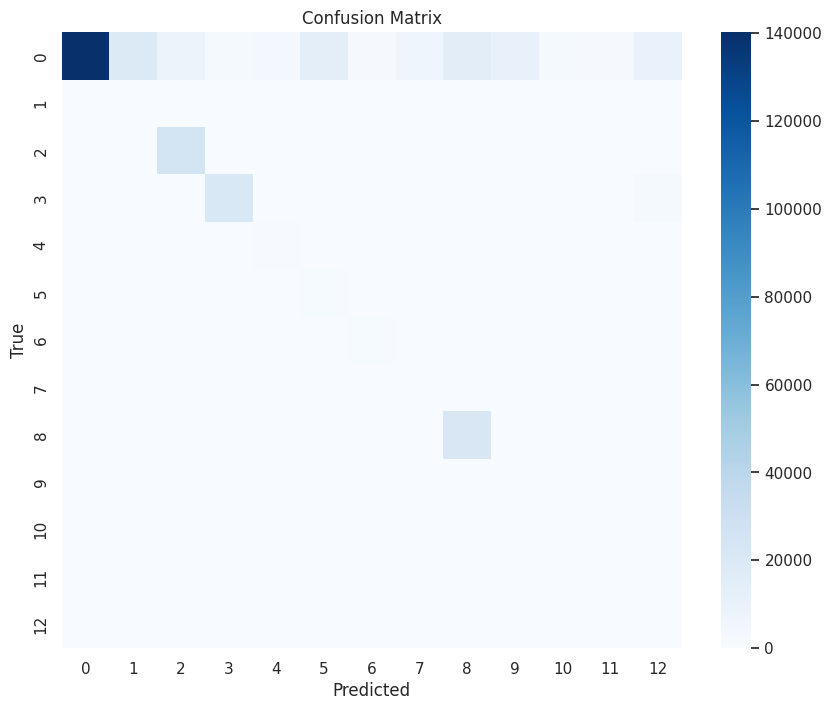

In [10]:
# Test evaluation
model.eval()
from math import isnan

test_loss = 0.0
test_acc = 0.0
num_test = 0
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        out = model(xb)
        loss = criterion(out, yb.long())
        test_loss += loss.item() * xb.size(0)
        test_acc += ((out.argmax(dim=1) == yb).float().mean().item()) * xb.size(0)
        num_test += xb.size(0)

test_loss /= max(1, num_test)
# average of per-batch accuracies weighted by batch size
correct = 0
count = 0
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        out = model(xb)
        preds = out.argmax(dim=1)
        correct += (preds == yb).sum().item()
        count += xb.size(0)

test_acc = correct / max(1, count)
print(f'Test: loss={test_loss:.4f} acc={test_acc:.4f}')

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

all_preds = []
all_true = []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        out = model(xb)
        all_preds.extend(out.argmax(dim=1).cpu().numpy())
        all_true.extend(yb.cpu().numpy())

cm = confusion_matrix(all_true, all_preds)
print('Classification report:')
print(classification_report(all_true, all_preds, target_names=class_names))

import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


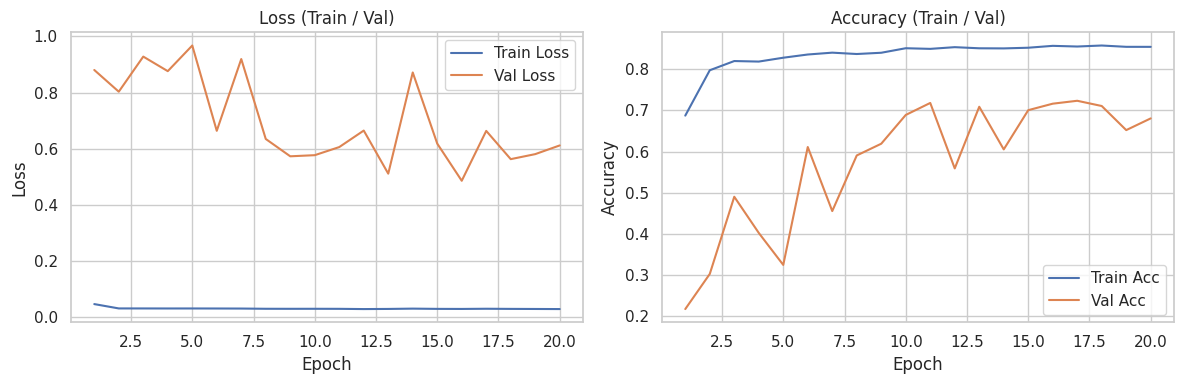

In [11]:
# Curves
fig, axes = plt.subplots(1, 2, figsize=(12,4))
x_epochs = list(range(1, len(history['train_loss']) + 1))
axes[0].plot(x_epochs, history['train_loss'], label='Train Loss')
axes[0].plot(x_epochs, history['val_loss'], label='Val Loss')
axes[0].set_title('Loss (Train / Val)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(loc='best')
axes[1].plot(x_epochs, history['train_acc'], label='Train Acc')
axes[1].plot(x_epochs, history['val_acc'], label='Val Acc')
axes[1].set_title('Accuracy (Train / Val)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(loc='best')
plt.tight_layout()
plt.show()


### Notes
- Automatically selects all numeric features (excluding label/meta columns) to cover a broader attack surface beyond DoS patterns.
- Uses stratified 60/20/20 split (train/val/test) with a compact MLP architecture.
- Applies per-class weighting + `WeightedRandomSampler` to counter strong class imbalance and lift minority recall/precision.
- Adjust `NROWS_PER_CSV`, `EPOCHS`, and model width as needed for runtime/performance.


In [12]:
# Save artifacts (optional)
ARTIFACTS_DIR = os.path.join(os.getcwd(), 'artifacts')
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# Save model
model_path = os.path.join(ARTIFACTS_DIR, 'dos_mlp.pt')
torch.save(model.state_dict(), model_path)
print('Saved model to:', model_path)

# Save scaler stats for reproducible preprocessing
scaler_path = os.path.join(ARTIFACTS_DIR, 'scaler_stats.npz')
np.savez(scaler_path, mean=X_mean.values, std=X_std.values, columns=np.array(X_df.columns))
print('Saved scaler to:', scaler_path)

# Save class mapping
classes_path = os.path.join(ARTIFACTS_DIR, 'classes.txt')
with open(classes_path, 'w') as f:
    for cname in class_names:
        f.write(str(cname) + '\n')
print('Saved classes to:', classes_path)


Saved model to: /app/artifacts/dos_mlp.pt
Saved scaler to: /app/artifacts/scaler_stats.npz
Saved classes to: /app/artifacts/classes.txt
